In [1]:
%load_ext autoreload
%autoreload 2

In [28]:
import numpy as np
import cv2 as cv
import random
import matplotlib.pyplot as plt

In [3]:
from fundamental_matrix import keypoint_matcher, get_fundamental_matrix, draw_epipolar_lines, get_fundamental_matrix_ransac

# Matching

In [363]:
image1 = cv.imread("../Data/House/frame00000001.png")
image2 = cv.imread("../Data/House/frame00000002.png")

Before filtering neighbours: 543. After: 450
Before filtering by L2 norm with threshold 0.15: 450. After: 18


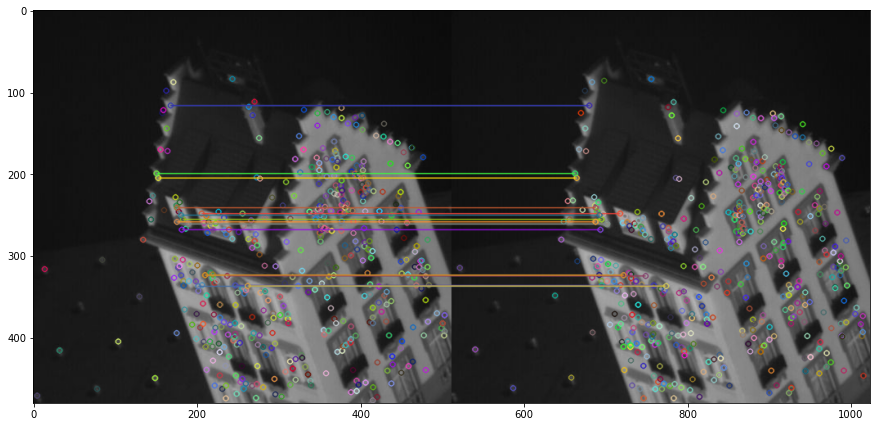

In [374]:
matches, matched_points1, matched_points2, kp1, kp2 = keypoint_matcher(image1, image2, 
                                                                       n_points=20, 
                                                                       distance_threshold=0.15,
                                                                       random_selection=False, 
                                                                       filter_neighbours=True, 
                                                                       draw_matches=True)

In [375]:
[m[0].distance for m in matches]

[8.426149368286133,
 10.488088607788086,
 11.401754379272461,
 13.190905570983887,
 15.0,
 15.033296585083008,
 15.459625244140625,
 16.970561981201172,
 18.055469512939453,
 18.867961883544922,
 22.516660690307617,
 28.301942825317383,
 28.809720993041992,
 31.160873413085938,
 32.06243896484375,
 33.09078598022461,
 73.25981140136719,
 77.88452911376953]

In [376]:
[np.linalg.norm(np.array(p1)-np.array(p2)) for p1, p2 in zip(matched_points1, matched_points2)]

[0.13470990127718457,
 0.09231244546589051,
 0.13470990127718457,
 0.1463027408161432,
 0.14256826866387934,
 0.10113406713016168,
 0.09231244546589051,
 0.127810474535054,
 0.034843497446453535,
 0.054650813808406654,
 0.05055173256909472,
 0.1364783463964474,
 0.09107805666934866,
 0.14866772165275172,
 0.116312499505227,
 0.1463027408161432,
 0.08200815562588643,
 0.13016909137113863]

In [338]:
sorted(matched_points1, key=lambda x: x[0])

[(143.979248046875, 255.46188354492188),
 (155.6320037841797, 169.92083740234375),
 (162.98277282714844, 144.24075317382812),
 (164.10728454589844, 171.78672790527344),
 (175.88623046875, 241.01461791992188),
 (200.5713653564453, 311.4892883300781),
 (219.64443969726562, 322.5149230957031),
 (223.0852813720703, 259.9809265136719),
 (237.13021850585938, 324.23199462890625),
 (255.84498596191406, 248.14486694335938),
 (267.6719970703125, 374.4859924316406),
 (277.82183837890625, 344.7418518066406),
 (281.6067199707031, 366.4359436035156),
 (282.9261779785156, 311.8427429199219),
 (286.8378601074219, 381.4084777832031),
 (292.5169677734375, 393.9376220703125),
 (311.3413391113281, 371.0063171386719),
 (317.0397033691406, 325.7002868652344),
 (323.9646301269531, 336.4670104980469),
 (327.08941650390625, 292.89544677734375)]

In [339]:
sorted(matched_points2, key=lambda x: x[0])

[(139.24681091308594, 243.31483459472656),
 (168.41525268554688, 164.57261657714844),
 (175.87417602539062, 169.19515991210938),
 (180.32879638671875, 142.99551391601562),
 (182.4463348388672, 228.87322998046875),
 (190.0423126220703, 306.20721435546875),
 (210.8900146484375, 322.0686950683594),
 (230.95022583007812, 320.4200439453125),
 (234.574951171875, 250.08499145507812),
 (251.11444091796875, 379.6087646484375),
 (269.193359375, 234.0177459716797),
 (271.0558776855469, 369.86981201171875),
 (272.1470947265625, 387.3183898925781),
 (275.1847839355469, 401.1245422363281),
 (275.4027404785156, 342.1343078613281),
 (298.7981262207031, 309.7920837402344),
 (301.590087890625, 375.2310791015625),
 (329.6985168457031, 326.8335266113281),
 (331.45733642578125, 340.6944274902344),
 (342.8011169433594, 301.1075439453125)]

# Normalization

In [6]:
from fundamental_matrix import normalize_points

In [7]:
matched_points1_norm, T = normalize_points(matched_points1)

mean x: 329.13, mean y: 229.54, average distance to the mean: 121.591


Check and show that the set of points {p_hat} with homogeneous coordinates satisfies our criteria.

In [8]:
normalize_points(matched_points1_norm);

mean x: 0.0, mean y: -0.0, average distance to the mean: 1.414


In [9]:
matched_points2_norm, T_prime = normalize_points(matched_points2)

mean x: 323.659, mean y: 267.613, average distance to the mean: 141.221


In [10]:
normalize_points(matched_points2_norm);

mean x: 0.0, mean y: -0.0, average distance to the mean: 1.414


# Fundamental matrix

In [340]:
F_ours = get_fundamental_matrix(matched_points1, matched_points2, normalize=True)
F_ours

mean x: 245.384, mean y: 297.385, average distance to the mean: 84.301
mean x: 246.561, mean y: 295.773, average distance to the mean: 88.652
U, D, V_t = np.linalg.svd(A) (20, 20) (9,) (9, 9)
V_t.T[:, n - 1]
[-0.03524005 -0.00822084  0.69423164  0.07042544 -0.05215702 -0.31203073
 -0.61989587  0.15188153  0.06596077]
(9,)
F
[[-0.03524005 -0.00822084  0.69423164]
 [ 0.07042544 -0.05215702 -0.31203073]
 [-0.61989587  0.15188153  0.06596077]]
(3, 3)
FD_prime [0.78895859 0.61330405 0.03744983]
FD_prime with the smallest singular value zeroed [0.78895859 0.61330405 0.        ]


array([[-8.45301455e-06,  1.69209632e-06,  1.26462674e-02],
       [ 2.10721169e-05, -5.09963396e-06, -8.63063409e-03],
       [-1.45329814e-02,  3.69724029e-03,  1.27380230e+00]])

In [341]:
F_cv = cv.findFundamentalMat(np.float64(matched_points1), np.float64(matched_points2), cv.FM_8POINT)[0]
F_cv

array([[-7.20007131e-06,  1.79487145e-05, -1.19821547e-02],
       [ 1.44128631e-06, -4.34374364e-06,  3.04897828e-03],
       [ 1.12694320e-02, -7.59824297e-03,  1.00000000e+00]])

Q: Why they do not coinside for normalized 8 points algo?

In [129]:
cv.findFundamentalMat(np.float32(matched_points1), np.float32(matched_points2), cv.FM_LMEDS)[0]

array([[ 8.50313025e-06,  2.32534932e-05, -3.83919514e-02],
       [-2.26661892e-05,  4.45460235e-06, -2.68679636e-02],
       [ 4.22806252e-02,  1.69479207e-02,  1.00000000e+00]])

In [131]:
cv.findFundamentalMat(np.float64(matched_points1), np.float64(matched_points2), cv.FM_RANSAC, 1)[0]

array([[-1.75746311e-06,  2.02888505e-05, -7.33231739e-02],
       [-2.02487782e-05,  8.98889453e-06, -6.32090703e-02],
       [ 9.25380915e-02,  4.17060474e-02,  1.00000000e+00]])

In [132]:
F = get_fundamental_matrix_ransac(matched_points1, matched_points2, threshold=1, iterations=1000)

mean x: 365.212, mean y: 228.569, average distance to the mean: 89.731
mean x: 358.261, mean y: 273.113, average distance to the mean: 110.414
U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[-0.04976694  0.01773556 -0.42521946 -0.0283277   0.01871567 -0.47866462
  0.32148893  0.69379386  0.03767626]
(9,)
F
[[-0.04976694  0.01773556 -0.42521946]
 [-0.0283277   0.01871567 -0.47866462]
 [ 0.32148893  0.69379386  0.03767626]]
(3, 3)
FD_prime [0.76770038 0.64058359 0.01699382]
FD_prime with the smallest singular value zeroed [0.76770038 0.64058359 0.        ]
mean x: 342.657, mean y: 202.016, average distance to the mean: 107.657
mean x: 298.656, mean y: 242.215, average distance to the mean: 134.539
U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[ 0.03777216 -0.4344893  -0.0269929   0.25849761  0.58975268  0.4959027
  0.03768674 -0.37441627 -0.08310918]
(9,)
F
[[ 0.03777216 -0.4344893  -0.0269929 ]
 [ 0.25849761  0.58975268  0.4959027 ]
 [ 0.03768674 -0.37

mean x: 383.424, mean y: 257.045, average distance to the mean: 90.297
mean x: 331.348, mean y: 300.206, average distance to the mean: 119.738
U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[ 0.5394404  -0.03195247  0.33022809 -0.06109049  0.02868792  0.394625
 -0.37900499 -0.54124051  0.04541463]
(9,)
F
[[ 0.5394404  -0.03195247  0.33022809]
 [-0.06109049  0.02868792  0.394625  ]
 [-0.37900499 -0.54124051  0.04541463]]
(3, 3)
FD_prime [0.77330285 0.54804406 0.31882662]
FD_prime with the smallest singular value zeroed [0.77330285 0.54804406 0.        ]
mean x: 317.852, mean y: 177.55, average distance to the mean: 91.452
mean x: 313.384, mean y: 194.999, average distance to the mean: 107.829
U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[ 0.11880129 -0.46662408  0.157627    0.07169431  0.69175971 -0.38131527
 -0.17716591  0.28712554 -0.02000505]
(9,)
F
[[ 0.11880129 -0.46662408  0.157627  ]
 [ 0.07169431  0.69175971 -0.38131527]
 [-0.17716591  0.28712

mean x: 377.459, mean y: 243.825, average distance to the mean: 108.702
mean x: 384.739, mean y: 284.916, average distance to the mean: 102.12
U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[-0.04675008  0.03925844  0.67044939 -0.0998254  -0.01997881 -0.0132261
 -0.71297985 -0.15411678  0.06433799]
(9,)
F
[[-0.04675008  0.03925844  0.67044939]
 [-0.0998254  -0.01997881 -0.0132261 ]
 [-0.71297985 -0.15411678  0.06433799]]
(3, 3)
FD_prime [0.76363234 0.64564376 0.00312804]
FD_prime with the smallest singular value zeroed [0.76363234 0.64564376 0.        ]
mean x: 374.26, mean y: 224.217, average distance to the mean: 91.526
mean x: 360.534, mean y: 272.634, average distance to the mean: 115.353
U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[ 0.03232093 -0.04364565  0.43566913  0.06610958  0.00176068  0.47014803
 -0.32462959 -0.69020418 -0.00799314]
(9,)
F
[[ 0.03232093 -0.04364565  0.43566913]
 [ 0.06610958  0.00176068  0.47014803]
 [-0.32462959 -0.6902

mean x: 325.765, mean y: 195.389, average distance to the mean: 88.568
U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[ 0.01641297  0.21800634  0.21304983 -0.09080869 -0.04791073  0.57936119
 -0.13189937 -0.73237148 -0.08274752]
(9,)
F
[[ 0.01641297  0.21800634  0.21304983]
 [-0.09080869 -0.04791073  0.57936119]
 [-0.13189937 -0.73237148 -0.08274752]]
(3, 3)
FD_prime [0.79164507 0.6109728  0.00321349]
FD_prime with the smallest singular value zeroed [0.79164507 0.6109728  0.        ]
mean x: 327.972, mean y: 229.034, average distance to the mean: 137.247
mean x: 311.04, mean y: 267.246, average distance to the mean: 144.094
U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[-0.0300736  -0.13696126 -0.34475342  0.08125335  0.01719701 -0.61606755
  0.16186918  0.65803087  0.12585288]
(9,)
F
[[-0.0300736  -0.13696126 -0.34475342]
 [ 0.08125335  0.01719701 -0.61606755]
 [ 0.16186918  0.65803087  0.12585288]]
(3, 3)
FD_prime [0.78219583 0.62230317 0.03014062]


mean x: 294.854, mean y: 217.934, average distance to the mean: 99.742
mean x: 296.994, mean y: 257.729, average distance to the mean: 151.411
U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[ 0.12161952  0.09632788  0.14430852 -0.22795747 -0.02951159  0.54130885
 -0.21704885 -0.72574946 -0.18823226]
(9,)
F
[[ 0.12161952  0.09632788  0.14430852]
 [-0.22795747 -0.02951159  0.54130885]
 [-0.21704885 -0.72574946 -0.18823226]]
(3, 3)
FD_prime [0.80036389 0.58758996 0.11897765]
FD_prime with the smallest singular value zeroed [0.80036389 0.58758996 0.        ]
mean x: 294.786, mean y: 235.544, average distance to the mean: 136.795
mean x: 293.248, mean y: 274.053, average distance to the mean: 159.862
U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[-0.01564826  0.1007542   0.54601352 -0.1828235  -0.00088651  0.36492941
 -0.54934817 -0.47224071 -0.00891989]
(9,)
F
[[-0.01564826  0.1007542   0.54601352]
 [-0.1828235  -0.00088651  0.36492941]
 [-0.54934817 -0.4

FD_prime [0.83500088 0.54851188 0.04368339]
FD_prime with the smallest singular value zeroed [0.83500088 0.54851188 0.        ]
mean x: 324.16, mean y: 218.71, average distance to the mean: 127.93
mean x: 311.304, mean y: 254.008, average distance to the mean: 147.316
U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[ 0.06815015  0.43921878 -0.51624459 -0.4115472  -0.37875254  0.20550743
  0.38194526  0.18705663  0.00192196]
(9,)
F
[[ 0.06815015  0.43921878 -0.51624459]
 [-0.4115472  -0.37875254  0.20550743]
 [ 0.38194526  0.18705663  0.00192196]]
(3, 3)
FD_prime [0.89506682 0.44587739 0.00698104]
FD_prime with the smallest singular value zeroed [0.89506682 0.44587739 0.        ]
mean x: 349.752, mean y: 211.689, average distance to the mean: 103.042
mean x: 345.443, mean y: 249.742, average distance to the mean: 126.235
U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[ 0.00431534 -0.45382618  0.37324827  0.43027969  0.10841314 -0.34851961
 -0.48865766  0

mean x: 374.653, mean y: 243.227, average distance to the mean: 106.413
mean x: 356.887, mean y: 275.081, average distance to the mean: 119.535
U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[-0.27086362  0.52443012  0.30110982 -0.60314777 -0.11641456  0.20695645
 -0.32761297 -0.11711971  0.14043141]
(9,)
F
[[-0.27086362  0.52443012  0.30110982]
 [-0.60314777 -0.11641456  0.20695645]
 [-0.32761297 -0.11711971  0.14043141]]
(3, 3)
FD_prime [0.82834891 0.55907681 0.03565412]
FD_prime with the smallest singular value zeroed [0.82834891 0.55907681 0.        ]
mean x: 376.47, mean y: 231.953, average distance to the mean: 105.258
mean x: 390.421, mean y: 268.437, average distance to the mean: 104.382
U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[-0.0286986   0.17103269 -0.63431861 -0.19705614 -0.06516552 -0.23846289
  0.57016115  0.37474044 -0.04591024]
(9,)
F
[[-0.0286986   0.17103269 -0.63431861]
 [-0.19705614 -0.06516552 -0.23846289]
 [ 0.57016115  0.3

U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[ 0.07472365 -0.20918642  0.25159554  0.28076172  0.08522941  0.49372424
  0.04883239 -0.74171482 -0.07054642]
(9,)
F
[[ 0.07472365 -0.20918642  0.25159554]
 [ 0.28076172  0.08522941  0.49372424]
 [ 0.04883239 -0.74171482 -0.07054642]]
(3, 3)
FD_prime [0.77920629 0.62242711 0.07363456]
FD_prime with the smallest singular value zeroed [0.77920629 0.62242711 0.        ]
mean x: 302.086, mean y: 214.482, average distance to the mean: 154.284
mean x: 313.509, mean y: 241.218, average distance to the mean: 166.251
U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[-0.16689481  0.5581535   0.13671602 -0.44857425 -0.19517615  0.35599989
 -0.01455009 -0.52460935  0.02107934]
(9,)
F
[[-0.16689481  0.5581535   0.13671602]
 [-0.44857425 -0.19517615  0.35599989]
 [-0.01455009 -0.52460935  0.02107934]]
(3, 3)
FD_prime [0.79052023 0.61238854 0.00761899]
FD_prime with the smallest singular value zeroed [0.79052023 0.6123885

mean x: 371.442, mean y: 222.02, average distance to the mean: 99.154
mean x: 334.18, mean y: 277.945, average distance to the mean: 140.003
U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[-0.05019622 -0.06378687 -0.30035394  0.07503386 -0.01080582 -0.55772212
  0.17781854  0.73636891  0.1119807 ]
(9,)
F
[[-0.05019622 -0.06378687 -0.30035394]
 [ 0.07503386 -0.01080582 -0.55772212]
 [ 0.17781854  0.73636891  0.1119807 ]]
(3, 3)
FD_prime [0.79305549 0.60575166 0.06424894]
FD_prime with the smallest singular value zeroed [0.79305549 0.60575166 0.        ]
mean x: 385.602, mean y: 240.412, average distance to the mean: 94.243
mean x: 397.213, mean y: 279.755, average distance to the mean: 92.071
U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[-1.42498761e-02  1.88622600e-02  6.26660175e-01 -2.49968457e-02
 -7.69937295e-04  3.60694143e-01 -4.97028252e-01 -4.78513727e-01
 -1.07006204e-04]
(9,)
F
[[-1.42498761e-02  1.88622600e-02  6.26660175e-01]
 [-2.4996845

U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[ 0.05323734 -0.50824878 -0.14453784  0.63352072  0.14483657 -0.31976382
  0.00162761  0.36789226  0.24090531]
(9,)
F
[[ 0.05323734 -0.50824878 -0.14453784]
 [ 0.63352072  0.14483657 -0.31976382]
 [ 0.00162761  0.36789226  0.24090531]]
(3, 3)
FD_prime [0.72836361 0.67693037 0.10607418]
FD_prime with the smallest singular value zeroed [0.72836361 0.67693037 0.        ]
mean x: 341.368, mean y: 211.1, average distance to the mean: 123.302
mean x: 359.975, mean y: 241.614, average distance to the mean: 125.215
U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[-0.02760135  0.03164496 -0.53472388 -0.06004617 -0.01596822 -0.47360438
  0.36720717  0.58970847  0.03934852]
(9,)
F
[[-0.02760135  0.03164496 -0.53472388]
 [-0.06004617 -0.01596822 -0.47360438]
 [ 0.36720717  0.58970847  0.03934852]]
(3, 3)
FD_prime [0.73812817 0.67463906 0.00537978]
FD_prime with the smallest singular value zeroed [0.73812817 0.67463906 

mean x: 339.327, mean y: 283.244, average distance to the mean: 120.494
mean x: 315.193, mean y: 340.057, average distance to the mean: 149.057
U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[-0.07845545  0.14799699 -0.38235123 -0.09569457 -0.04264139 -0.47282372
  0.34779825  0.66972868  0.14734663]
(9,)
F
[[-0.07845545  0.14799699 -0.38235123]
 [-0.09569457 -0.04264139 -0.47282372]
 [ 0.34779825  0.66972868  0.14734663]]
(3, 3)
FD_prime [0.79934976 0.5980519  0.05808521]
FD_prime with the smallest singular value zeroed [0.79934976 0.5980519  0.        ]
mean x: 306.384, mean y: 249.035, average distance to the mean: 142.104
mean x: 313.975, mean y: 293.746, average distance to the mean: 169.642
U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[ 0.04506219  0.42646003 -0.38187267 -0.7171919   0.009438   -0.00682873
  0.34737348  0.17779176 -0.0591298 ]
(9,)
F
[[ 0.04506219  0.42646003 -0.38187267]
 [-0.7171919   0.009438   -0.00682873]
 [ 0.34737348  0.

(3, 3)
FD_prime [0.73533948 0.67759225 0.01202449]
FD_prime with the smallest singular value zeroed [0.73533948 0.67759225 0.        ]
mean x: 297.923, mean y: 219.746, average distance to the mean: 141.606
mean x: 252.493, mean y: 274.827, average distance to the mean: 179.821
U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[ 0.27340897 -0.17578794  0.56021283  0.22368692  0.07254413 -0.49492566
 -0.51244374 -0.00217577 -0.13287023]
(9,)
F
[[ 0.27340897 -0.17578794  0.56021283]
 [ 0.22368692  0.07254413 -0.49492566]
 [-0.51244374 -0.00217577 -0.13287023]]
(3, 3)
FD_prime [0.81037109 0.58192845 0.06824941]
FD_prime with the smallest singular value zeroed [0.81037109 0.58192845 0.        ]
mean x: 310.077, mean y: 236.259, average distance to the mean: 151.447
mean x: 316.922, mean y: 263.424, average distance to the mean: 156.376
U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[-0.01661859 -0.08766115  0.72621194  0.025229    0.04488694  0.01052846
 -0.6

mean x: 369.645, mean y: 191.522, average distance to the mean: 94.238
mean x: 372.716, mean y: 244.83, average distance to the mean: 123.118
U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[-0.02454786  0.05425484  0.49164642 -0.00773025 -0.09238564  0.35003989
 -0.51575398 -0.59364281  0.0721171 ]
(9,)
F
[[-0.02454786  0.05425484  0.49164642]
 [-0.00773025 -0.09238564  0.35003989]
 [-0.51575398 -0.59364281  0.0721171 ]]
(3, 3)
FD_prime [0.80181972 0.59278086 0.07547181]
FD_prime with the smallest singular value zeroed [0.80181972 0.59278086 0.        ]
mean x: 304.51, mean y: 233.218, average distance to the mean: 126.562
mean x: 288.335, mean y: 284.926, average distance to the mean: 155.568
U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[-0.06766362  0.22891981 -0.49754349 -0.32152563 -0.2302951  -0.24300309
  0.44463041  0.50386834  0.168592  ]
(9,)
F
[[-0.06766362  0.22891981 -0.49754349]
 [-0.32152563 -0.2302951  -0.24300309]
 [ 0.44463041  0.503

mean x: 354.345, mean y: 212.484, average distance to the mean: 139.587
mean x: 338.194, mean y: 264.265, average distance to the mean: 160.56
U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[-0.0216042   0.13933605 -0.52619305 -0.20962314 -0.02258367 -0.35233835
  0.39460771  0.61519854 -0.02146891]
(9,)
F
[[-0.0216042   0.13933605 -0.52619305]
 [-0.20962314 -0.02258367 -0.35233835]
 [ 0.39460771  0.61519854 -0.02146891]]
(3, 3)
FD_prime [0.75269143 0.65371335 0.07819504]
FD_prime with the smallest singular value zeroed [0.75269143 0.65371335 0.        ]
mean x: 333.945, mean y: 214.164, average distance to the mean: 125.149
mean x: 289.216, mean y: 260.397, average distance to the mean: 150.306
U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[ 0.21206194 -0.66157189 -0.2405407   0.30611562  0.36883741 -0.37275034
  0.10178835  0.27464619  0.07078503]
(9,)
F
[[ 0.21206194 -0.66157189 -0.2405407 ]
 [ 0.30611562  0.36883741 -0.37275034]
 [ 0.10178835  0.2

mean x: 374.333, mean y: 244.231, average distance to the mean: 84.494
U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[-0.20968232  0.38509951  0.31336429 -0.51758112 -0.12184402  0.50460982
 -0.14265156 -0.38230604  0.07523218]
(9,)
F
[[-0.20968232  0.38509951  0.31336429]
 [-0.51758112 -0.12184402  0.50460982]
 [-0.14265156 -0.38230604  0.07523218]]
(3, 3)
FD_prime [0.82659155 0.56268666 0.01140751]
FD_prime with the smallest singular value zeroed [0.82659155 0.56268666 0.        ]
mean x: 344.263, mean y: 261.864, average distance to the mean: 115.792
mean x: 324.544, mean y: 299.195, average distance to the mean: 127.609
U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[ 0.00635319 -0.16408115 -0.36500802  0.10336185  0.01818079 -0.57938667
  0.14068962  0.6834356   0.07890024]
(9,)
F
[[ 0.00635319 -0.16408115 -0.36500802]
 [ 0.10336185  0.01818079 -0.57938667]
 [ 0.14068962  0.6834356   0.07890024]]
(3, 3)
FD_prime [0.76888757 0.63919633 0.01549059]

U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[ 0.01518187 -0.06956122  0.45054785  0.18190213  0.10939818  0.42404602
 -0.35379816 -0.66428704 -0.0248114 ]
(9,)
F
[[ 0.01518187 -0.06956122  0.45054785]
 [ 0.18190213  0.10939818  0.42404602]
 [-0.35379816 -0.66428704 -0.0248114 ]]
(3, 3)
FD_prime [0.79114298 0.60982745 0.04693899]
FD_prime with the smallest singular value zeroed [0.79114298 0.60982745 0.        ]
mean x: 370.322, mean y: 265.201, average distance to the mean: 106.164
mean x: 368.645, mean y: 319.158, average distance to the mean: 126.298
U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[ 0.07048105 -0.00545333  0.40516469  0.00971079 -0.00634669  0.50657422
 -0.32539712 -0.67477283 -0.1135367 ]
(9,)
F
[[ 0.07048105 -0.00545333  0.40516469]
 [ 0.00971079 -0.00634669  0.50657422]
 [-0.32539712 -0.67477283 -0.1135367 ]]
(3, 3)
FD_prime [0.78268046 0.62084263 0.04433656]
FD_prime with the smallest singular value zeroed [0.78268046 0.6208426

mean x: 384.561, mean y: 248.77, average distance to the mean: 101.705
mean x: 396.715, mean y: 288.697, average distance to the mean: 101.309
U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[ 0.15802107 -0.54848379 -0.40371108  0.47562138  0.17222977  0.02636683
  0.41437402  0.27407488  0.08840461]
(9,)
F
[[ 0.15802107 -0.54848379 -0.40371108]
 [ 0.47562138  0.17222977  0.02636683]
 [ 0.41437402  0.27407488  0.08840461]]
(3, 3)
FD_prime [0.77801349 0.62814747 0.01121446]
FD_prime with the smallest singular value zeroed [0.77801349 0.62814747 0.        ]
mean x: 319.445, mean y: 264.459, average distance to the mean: 105.828
mean x: 332.9, mean y: 282.383, average distance to the mean: 115.552
U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[ 0.08031749 -0.14462736  0.45674535  0.13499129  0.02678873  0.52305065
 -0.30415633 -0.61355732 -0.05029695]
(9,)
F
[[ 0.08031749 -0.14462736  0.45674535]
 [ 0.13499129  0.02678873  0.52305065]
 [-0.30415633 -0.613

mean x: 294.821, mean y: 210.445, average distance to the mean: 176.641
mean x: 297.078, mean y: 263.714, average distance to the mean: 195.145
U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[ 0.07340701 -0.4102055   0.10246496  0.39200313  0.04682213  0.50955647
 -0.01420616 -0.62887259 -0.06822514]
(9,)
F
[[ 0.07340701 -0.4102055   0.10246496]
 [ 0.39200313  0.04682213  0.50955647]
 [-0.01420616 -0.62887259 -0.06822514]]
(3, 3)
FD_prime [0.75421826 0.65631889 0.02000843]
FD_prime with the smallest singular value zeroed [0.75421826 0.65631889 0.        ]
mean x: 328.376, mean y: 255.133, average distance to the mean: 142.469
mean x: 297.704, mean y: 321.934, average distance to the mean: 178.848
U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[ 0.07838809 -0.25081335  0.42870126  0.32129826 -0.01108582  0.29852315
 -0.49012038 -0.55959795 -0.03638403]
(9,)
F
[[ 0.07838809 -0.25081335  0.42870126]
 [ 0.32129826 -0.01108582  0.29852315]
 [-0.49012038 -0.

In [133]:
F

array([[ 3.44518997e-06, -8.72993047e-06,  7.32616143e-03],
       [ 9.91130013e-06,  2.75822913e-06,  1.24133145e-03],
       [-8.64044250e-03, -4.15963318e-03,  1.66781014e-01]])

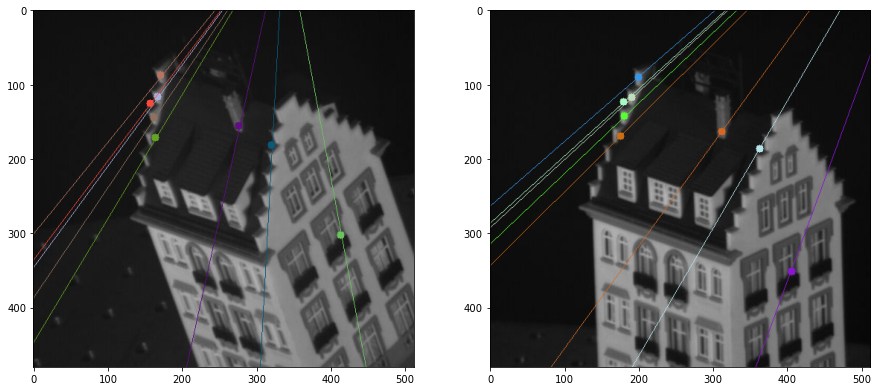

In [245]:
def drawlines(img1, img2, lines, pts1, pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r, c = img1.shape
    img1 = cv.cvtColor(img1, cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2, cv.COLOR_GRAY2BGR)
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        img1 = cv.line(img1, (x0, y0), (x1, y1), color, 1)
        img1 = cv.circle(img=img1, center=(int(pt1[0]), int(
            pt1[1])), radius=5, color=color, thickness=-1)
        img2 = cv.circle(img2, (int(pt2[0]), int(pt2[1])), 5, color, 2)
    return img1, img2


img1 = cv.cvtColor(image1, cv.COLOR_RGB2GRAY)
img2 = cv.cvtColor(image2, cv.COLOR_RGB2GRAY)


# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv.computeCorrespondEpilines(
    np.float64(matched_points2).reshape(-1, 1, 2), 2, F_cv)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img1, img2, lines1,
                       np.float64(matched_points1),
                       np.float64(matched_points2))
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(
    np.float64(matched_points1).reshape(-1, 1, 2), 1, F_cv)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img2, img1, lines2,
                       np.float64(matched_points2),
                       np.float64(matched_points1))
plt.figure(figsize=(15, 15))
plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
plt.show()

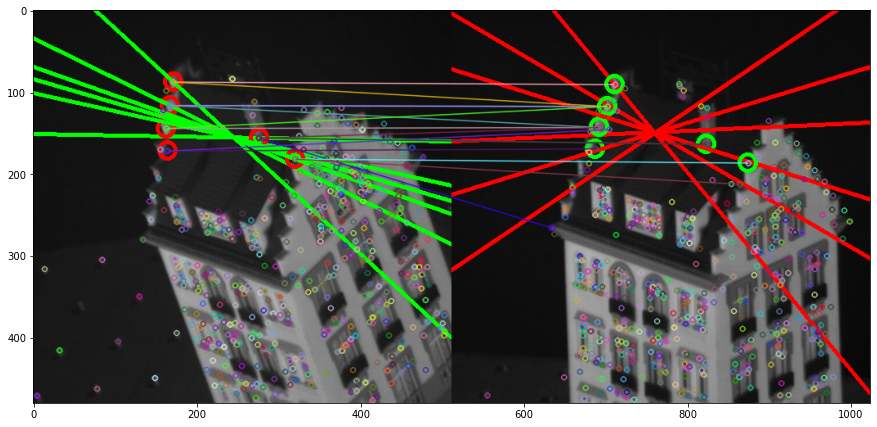

In [246]:
draw_epipolar_lines(image1, image2, matches, kp1, kp2, F)

# Chaining

Construct a point-view matrix for chaining multiple views with the matches found in last step using all consecutive house images (1-2, 2-3, 3-4, ..., 48-49, 49-1). Rows of the point-view matrix will be representing your images while columns will be points. For more details, you can refer to [2].
1. Start from any two consecutive image matches. Add a new column to point-view matrix for each newly introduced point.
2. If a point which is already introduced in the point-view matrix and another image contains that point, mark this matching on your point-view matrix using the previously defined point column. Do not introduce a new column.  

Together with the assignment a sample point view matrix (PointViewMatrix.txt) is provided to test and finish your pipeline (for the ones who have difficult time to build a point view matrix). This data has more images than provided for the assignment, however you can still use PVM to check correctness of the last part of your algorithm.

In [488]:
from chaining import get_names_image_pair, chaining

In [545]:
sparse_fill_value=-1e-4

In [715]:
PVM = chaining(sparse_fill_value=sparse_fill_value, 
               n_points=500, distance_threshold=1,) # a lot of points but very careful

  2%|▏         | 1/48 [00:00<00:06,  7.35it/s]

comparing table x indices (0, 2) and images ('../Data/House/frame00000001.png', '../Data/House/frame00000002.png')
Before filtering neighbours: 543. After: 450
Before filtering by L2 norm with threshold 1: 450. After: 329
comparing table x indices (2, 4) and images ('../Data/House/frame00000002.png', '../Data/House/frame00000003.png')


  6%|▋         | 3/48 [00:00<00:05,  7.93it/s]

Before filtering neighbours: 548. After: 447
Before filtering by L2 norm with threshold 1: 447. After: 191
comparing table x indices (4, 6) and images ('../Data/House/frame00000003.png', '../Data/House/frame00000004.png')
Before filtering neighbours: 526. After: 424
Before filtering by L2 norm with threshold 1: 424. After: 192
comparing table x indices (6, 8) and images ('../Data/House/frame00000004.png', '../Data/House/frame00000005.png')


 10%|█         | 5/48 [00:00<00:05,  7.72it/s]

Before filtering neighbours: 566. After: 450
Before filtering by L2 norm with threshold 1: 450. After: 192
comparing table x indices (8, 10) and images ('../Data/House/frame00000005.png', '../Data/House/frame00000006.png')
Before filtering neighbours: 525. After: 424
Before filtering by L2 norm with threshold 1: 424. After: 198
comparing table x indices (10, 12) and images ('../Data/House/frame00000006.png', '../Data/House/frame00000007.png')


 15%|█▍        | 7/48 [00:00<00:05,  7.20it/s]

Before filtering neighbours: 554. After: 437
Before filtering by L2 norm with threshold 1: 437. After: 214
comparing table x indices (12, 14) and images ('../Data/House/frame00000007.png', '../Data/House/frame00000008.png')
Before filtering neighbours: 534. After: 434
Before filtering by L2 norm with threshold 1: 434. After: 214
comparing table x indices (14, 16) and images ('../Data/House/frame00000008.png', '../Data/House/frame00000009.png')


 19%|█▉        | 9/48 [00:01<00:05,  7.24it/s]

Before filtering neighbours: 540. After: 448
Before filtering by L2 norm with threshold 1: 448. After: 228
comparing table x indices (16, 18) and images ('../Data/House/frame00000009.png', '../Data/House/frame00000010.png')
Before filtering neighbours: 561. After: 455
Before filtering by L2 norm with threshold 1: 455. After: 211
comparing table x indices (18, 20) and images ('../Data/House/frame00000010.png', '../Data/House/frame00000011.png')


 23%|██▎       | 11/48 [00:01<00:04,  7.50it/s]

Before filtering neighbours: 549. After: 453
Before filtering by L2 norm with threshold 1: 453. After: 227
comparing table x indices (20, 22) and images ('../Data/House/frame00000011.png', '../Data/House/frame00000012.png')
Before filtering neighbours: 550. After: 440
Before filtering by L2 norm with threshold 1: 440. After: 237
comparing table x indices (22, 24) and images ('../Data/House/frame00000012.png', '../Data/House/frame00000013.png')


 27%|██▋       | 13/48 [00:01<00:04,  7.30it/s]

Before filtering neighbours: 555. After: 452
Before filtering by L2 norm with threshold 1: 452. After: 239
comparing table x indices (24, 26) and images ('../Data/House/frame00000013.png', '../Data/House/frame00000014.png')
Before filtering neighbours: 558. After: 450
Before filtering by L2 norm with threshold 1: 450. After: 244
comparing table x indices (26, 28) and images ('../Data/House/frame00000014.png', '../Data/House/frame00000015.png')


 31%|███▏      | 15/48 [00:02<00:04,  7.33it/s]

Before filtering neighbours: 573. After: 479
Before filtering by L2 norm with threshold 1: 479. After: 267
comparing table x indices (28, 30) and images ('../Data/House/frame00000015.png', '../Data/House/frame00000016.png')
Before filtering neighbours: 573. After: 457
Before filtering by L2 norm with threshold 1: 457. After: 262
comparing table x indices (30, 32) and images ('../Data/House/frame00000016.png', '../Data/House/frame00000017.png')


 35%|███▌      | 17/48 [00:02<00:04,  7.35it/s]

Before filtering neighbours: 549. After: 458
Before filtering by L2 norm with threshold 1: 458. After: 243
comparing table x indices (32, 34) and images ('../Data/House/frame00000017.png', '../Data/House/frame00000018.png')
Before filtering neighbours: 571. After: 476
Before filtering by L2 norm with threshold 1: 476. After: 264
comparing table x indices (34, 36) and images ('../Data/House/frame00000018.png', '../Data/House/frame00000019.png')


 40%|███▉      | 19/48 [00:02<00:04,  6.98it/s]

Before filtering neighbours: 584. After: 475
Before filtering by L2 norm with threshold 1: 475. After: 274
comparing table x indices (36, 38) and images ('../Data/House/frame00000019.png', '../Data/House/frame00000020.png')
Before filtering neighbours: 561. After: 462
Before filtering by L2 norm with threshold 1: 462. After: 274
comparing table x indices (38, 40) and images ('../Data/House/frame00000020.png', '../Data/House/frame00000021.png')


 44%|████▍     | 21/48 [00:02<00:03,  7.09it/s]

Before filtering neighbours: 579. After: 469
Before filtering by L2 norm with threshold 1: 469. After: 293
comparing table x indices (40, 42) and images ('../Data/House/frame00000021.png', '../Data/House/frame00000022.png')
Before filtering neighbours: 574. After: 478
Before filtering by L2 norm with threshold 1: 478. After: 262
comparing table x indices (42, 44) and images ('../Data/House/frame00000022.png', '../Data/House/frame00000023.png')


 48%|████▊     | 23/48 [00:03<00:03,  7.07it/s]

Before filtering neighbours: 560. After: 434
Before filtering by L2 norm with threshold 1: 434. After: 251
comparing table x indices (44, 46) and images ('../Data/House/frame00000023.png', '../Data/House/frame00000024.png')
Before filtering neighbours: 565. After: 452
Before filtering by L2 norm with threshold 1: 452. After: 269
comparing table x indices (46, 48) and images ('../Data/House/frame00000024.png', '../Data/House/frame00000025.png')


 52%|█████▏    | 25/48 [00:03<00:03,  6.82it/s]

Before filtering neighbours: 590. After: 485
Before filtering by L2 norm with threshold 1: 485. After: 298
comparing table x indices (48, 50) and images ('../Data/House/frame00000025.png', '../Data/House/frame00000026.png')
Before filtering neighbours: 572. After: 458
Before filtering by L2 norm with threshold 1: 458. After: 277


 54%|█████▍    | 26/48 [00:03<00:03,  6.78it/s]

comparing table x indices (50, 52) and images ('../Data/House/frame00000026.png', '../Data/House/frame00000027.png')
Before filtering neighbours: 555. After: 441
Before filtering by L2 norm with threshold 1: 441. After: 285
comparing table x indices (52, 54) and images ('../Data/House/frame00000027.png', '../Data/House/frame00000028.png')


 56%|█████▋    | 27/48 [00:03<00:03,  6.74it/s]

Before filtering neighbours: 579. After: 435
Before filtering by L2 norm with threshold 1: 435. After: 295
comparing table x indices (54, 56) and images ('../Data/House/frame00000028.png', '../Data/House/frame00000029.png')
Before filtering neighbours: 578. After: 460
Before filtering by L2 norm with threshold 1: 460. After: 283


 60%|██████    | 29/48 [00:04<00:03,  5.94it/s]

comparing table x indices (56, 58) and images ('../Data/House/frame00000029.png', '../Data/House/frame00000030.png')
Before filtering neighbours: 543. After: 445
Before filtering by L2 norm with threshold 1: 445. After: 279
comparing table x indices (58, 60) and images ('../Data/House/frame00000030.png', '../Data/House/frame00000031.png')


 62%|██████▎   | 30/48 [00:04<00:03,  5.83it/s]

Before filtering neighbours: 567. After: 455
Before filtering by L2 norm with threshold 1: 455. After: 273
comparing table x indices (60, 62) and images ('../Data/House/frame00000031.png', '../Data/House/frame00000032.png')
Before filtering neighbours: 552. After: 441
Before filtering by L2 norm with threshold 1: 441. After: 281


 67%|██████▋   | 32/48 [00:04<00:02,  6.10it/s]

comparing table x indices (62, 64) and images ('../Data/House/frame00000032.png', '../Data/House/frame00000033.png')
Before filtering neighbours: 574. After: 469
Before filtering by L2 norm with threshold 1: 469. After: 310
comparing table x indices (64, 66) and images ('../Data/House/frame00000033.png', '../Data/House/frame00000034.png')


 69%|██████▉   | 33/48 [00:04<00:02,  6.19it/s]

Before filtering neighbours: 580. After: 436
Before filtering by L2 norm with threshold 1: 436. After: 289
comparing table x indices (66, 68) and images ('../Data/House/frame00000034.png', '../Data/House/frame00000035.png')
Before filtering neighbours: 546. After: 439
Before filtering by L2 norm with threshold 1: 439. After: 291


 73%|███████▎  | 35/48 [00:05<00:02,  6.08it/s]

comparing table x indices (68, 70) and images ('../Data/House/frame00000035.png', '../Data/House/frame00000036.png')
Before filtering neighbours: 571. After: 438
Before filtering by L2 norm with threshold 1: 438. After: 286
comparing table x indices (70, 72) and images ('../Data/House/frame00000036.png', '../Data/House/frame00000037.png')


 75%|███████▌  | 36/48 [00:05<00:02,  5.77it/s]

Before filtering neighbours: 543. After: 454
Before filtering by L2 norm with threshold 1: 454. After: 300
comparing table x indices (72, 74) and images ('../Data/House/frame00000037.png', '../Data/House/frame00000038.png')


 77%|███████▋  | 37/48 [00:05<00:02,  5.40it/s]

Before filtering neighbours: 567. After: 453
Before filtering by L2 norm with threshold 1: 453. After: 303
comparing table x indices (74, 76) and images ('../Data/House/frame00000038.png', '../Data/House/frame00000039.png')
Before filtering neighbours: 567. After: 458


 79%|███████▉  | 38/48 [00:05<00:01,  5.18it/s]

Before filtering by L2 norm with threshold 1: 458. After: 305
comparing table x indices (76, 78) and images ('../Data/House/frame00000039.png', '../Data/House/frame00000040.png')
Before filtering neighbours: 559. After: 452
Before filtering by L2 norm with threshold 1: 452. After: 319


 83%|████████▎ | 40/48 [00:06<00:01,  5.01it/s]

comparing table x indices (78, 80) and images ('../Data/House/frame00000040.png', '../Data/House/frame00000041.png')
Before filtering neighbours: 586. After: 465
Before filtering by L2 norm with threshold 1: 465. After: 329
comparing table x indices (80, 82) and images ('../Data/House/frame00000041.png', '../Data/House/frame00000042.png')
Before filtering neighbours: 583. After: 481
Before filtering by L2 norm with threshold 1: 481. After: 328


 88%|████████▊ | 42/48 [00:06<00:01,  4.87it/s]

comparing table x indices (82, 84) and images ('../Data/House/frame00000042.png', '../Data/House/frame00000043.png')
Before filtering neighbours: 577. After: 458
Before filtering by L2 norm with threshold 1: 458. After: 309
comparing table x indices (84, 86) and images ('../Data/House/frame00000043.png', '../Data/House/frame00000044.png')


 90%|████████▉ | 43/48 [00:06<00:01,  4.97it/s]

Before filtering neighbours: 563. After: 449
Before filtering by L2 norm with threshold 1: 449. After: 313
comparing table x indices (86, 88) and images ('../Data/House/frame00000044.png', '../Data/House/frame00000045.png')


 92%|█████████▏| 44/48 [00:06<00:00,  5.05it/s]

Before filtering neighbours: 537. After: 446
Before filtering by L2 norm with threshold 1: 446. After: 319
comparing table x indices (88, 90) and images ('../Data/House/frame00000045.png', '../Data/House/frame00000046.png')
Before filtering neighbours: 587. After: 481
Before filtering by L2 norm with threshold 1: 481. After: 355


 96%|█████████▌| 46/48 [00:07<00:00,  5.01it/s]

comparing table x indices (90, 92) and images ('../Data/House/frame00000046.png', '../Data/House/frame00000047.png')
Before filtering neighbours: 578. After: 462
Before filtering by L2 norm with threshold 1: 462. After: 330
comparing table x indices (92, 94) and images ('../Data/House/frame00000047.png', '../Data/House/frame00000048.png')


 98%|█████████▊| 47/48 [00:07<00:00,  5.10it/s]

Before filtering neighbours: 563. After: 452
Before filtering by L2 norm with threshold 1: 452. After: 319
comparing table x indices (94, 96) and images ('../Data/House/frame00000048.png', '../Data/House/frame00000049.png')
Before filtering neighbours: 556. After: 439
Before filtering by L2 norm with threshold 1: 439. After: 312


100%|██████████| 48/48 [00:07<00:00,  6.19it/s]


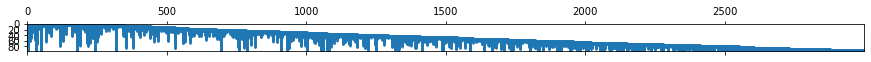

In [716]:
# Implementation of matplotlib spy function
import matplotlib.pyplot as plt
import numpy as np
 
    
plt.figure(figsize=(15, 10))
plt.spy(PVM, precision=-sparse_fill_value, markersize = 1);

In [717]:
PVM.shape

(98, 2998)

## Comparing with PointViewMatrix.txt

In [115]:
gt_pvm = np.loadtxt('../PointViewMatrix.txt')
gt_pvm.shape

(202, 215)

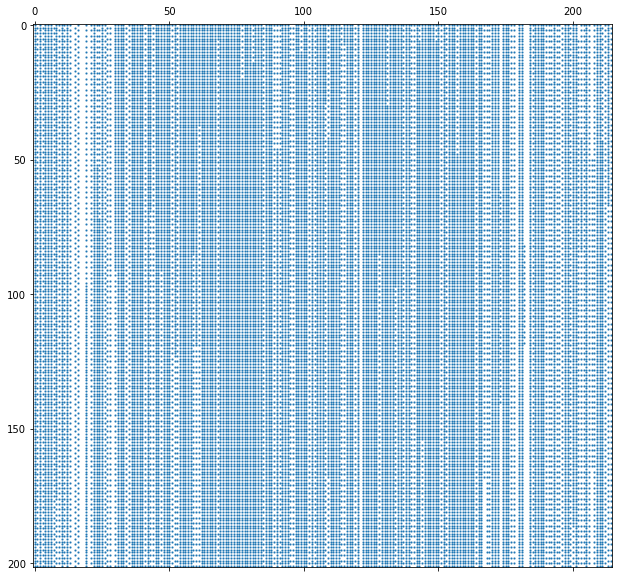

In [386]:
plt.figure(figsize=(15, 10))
plt.spy(gt_pvm, precision=200, markersize = 1);

Q: how to extract dense blocks?

# Chaining check

Before filtering neighbours: 543. After: 450
Before filtering neighbours: 548. After: 447


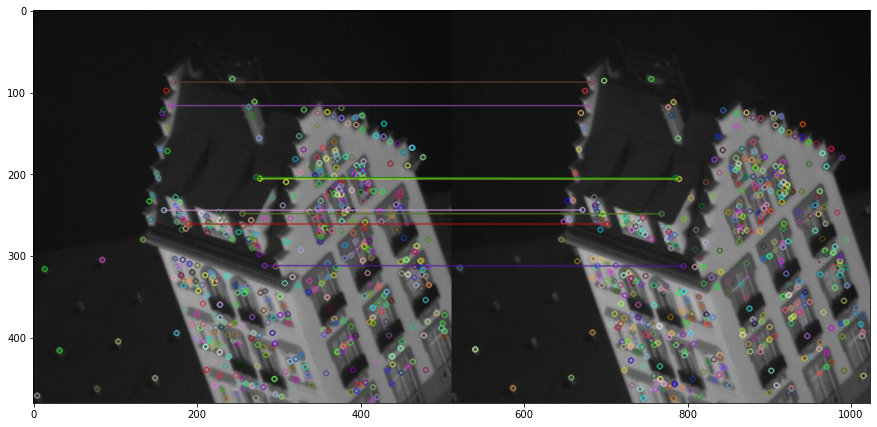

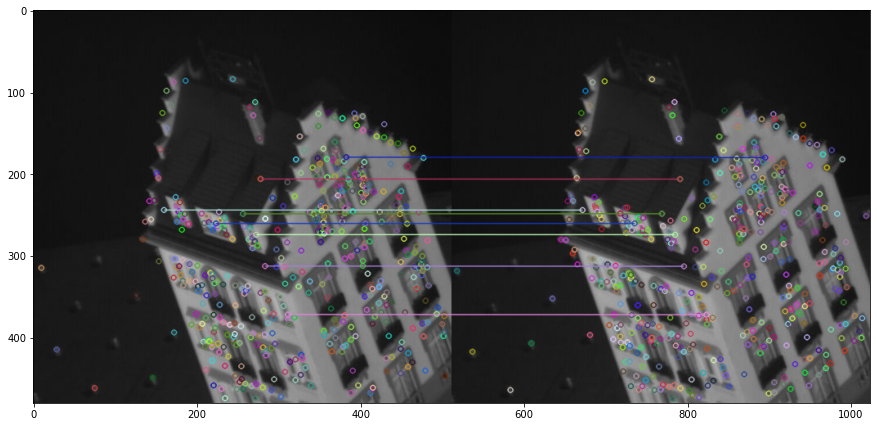

In [141]:
image1 = cv.imread("../Data/House/frame00000001.png")
image2 = cv.imread("../Data/House/frame00000002.png")
image3 = cv.imread("../Data/House/frame00000003.png")

_, matched_points12, matched_points21, _, _ = keypoint_matcher(
    image1, image2, n_points=8, random_selection=False, filter_neighbours=True, draw_matches=True)

_, matched_points23, matched_points32, _, _ = keypoint_matcher(
    image2, image3, n_points=8, random_selection=False, filter_neighbours=True, draw_matches=True)

In [144]:
sorted(matched_points21, key=lambda x: x[0])

[(159.84326171875, 243.7429656982422),
 (168.09413146972656, 116.17607879638672),
 (171.5107879638672, 87.54129791259766),
 (189.80917358398438, 260.8506774902344),
 (256.4742431640625, 248.44085693359375),
 (273.99774169921875, 204.6702880859375),
 (277.9999084472656, 205.9047088623047),
 (283.4146728515625, 312.2811279296875)]

In [145]:
sorted(matched_points23, key=lambda x: x[0])

[(159.84326171875, 243.7429656982422),
 (223.43911743164062, 260.18743896484375),
 (256.4742431640625, 248.44085693359375),
 (272.61663818359375, 273.8099670410156),
 (277.9999084472656, 205.9047088623047),
 (283.4146728515625, 312.2811279296875),
 (311.4600830078125, 371.3696594238281),
 (382.78680419921875, 179.23373413085938)]

In [11]:
PVM[2, :20]

array([ 2.77999908e+02,  1.59843262e+02,  1.68094131e+02,  2.73997742e+02,
        2.83414673e+02,  1.89809174e+02,  1.71510788e+02,  2.56474243e+02,
        2.23439117e+02,  3.82786804e+02,  2.77999908e+02,  2.72616638e+02,
        2.83414673e+02,  3.11460083e+02,  2.56474243e+02,  1.59843262e+02,
       -1.00000000e-04, -1.00000000e-04, -1.00000000e-04, -1.00000000e-04])

In [12]:
PVM[3, :20]

array([ 2.05904709e+02,  2.43742966e+02,  1.16176079e+02,  2.04670288e+02,
        3.12281128e+02,  2.60850677e+02,  8.75412979e+01,  2.48440857e+02,
        2.60187439e+02,  1.79233734e+02,  2.05904709e+02,  2.73809967e+02,
        3.12281128e+02,  3.71369659e+02,  2.48440857e+02,  2.43742966e+02,
       -1.00000000e-04, -1.00000000e-04, -1.00000000e-04, -1.00000000e-04])

# Structure from motion

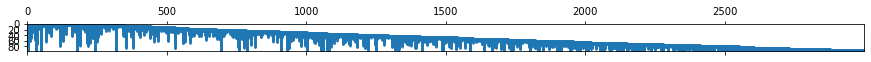

In [718]:
plt.figure(figsize=(15, 10))
plt.spy(PVM, precision=1e-4, markersize = 1);

In [719]:
from sfm import factorize_and_stitch

## GT PVM

In [644]:
gt_pvm.shape

(202, 215)

### Full

In [425]:
S = factorize_and_stitch(gt_pvm)
S.shape

2m:  202
n:  215


(3, 215)

In [435]:
trace_S = (S @ S.T).trace()
S_stand = S / np.sqrt(trace_S)

In [441]:
gt_pvm_point = o3d.geometry.PointCloud()
gt_pvm_point.points = o3d.utility.Vector3dVector(S_stand.T)
o3d.visualization.draw_geometries([gt_pvm_point])    

works perfect

### Vetrical split

In [445]:
S1 = factorize_and_stitch(gt_pvm[:, :100])
S2 = factorize_and_stitch(gt_pvm[:, 100: 200])
S1.shape, S2.shape

2m:  202
n:  100
2m:  202
n:  100


((3, 100), (3, 100))

In [446]:
mtx1, mtx2, disparity = procrustes(S1.T, S2.T)

trace_2 = (mtx2 @ mtx2.T).trace()
mtx2_stand = mtx2 / np.sqrt(trace_2)

assert np.isclose((mtx2_stand @ mtx2_stand.T).trace(), 1., 
                  rtol=1e-05, atol=1e-08)
assert np.isclose((mtx1 @ mtx1.T).trace(), 1., 
                  rtol=1e-05, atol=1e-08)

In [447]:
p1 = o3d.geometry.PointCloud()
p1.points = o3d.utility.Vector3dVector(mtx1)

p2 = o3d.geometry.PointCloud()
p2.points = o3d.utility.Vector3dVector(mtx2_stand)

o3d.visualization.draw_geometries([p1, p2]) 

In [449]:
o3d.visualization.draw_geometries([gt_pvm_point, p2]) 

works bad

### Horizontal halfs

In [451]:
S1 = factorize_and_stitch(gt_pvm[:100, :])
S2 = factorize_and_stitch(gt_pvm[100: 200, :])
S1.shape, S2.shape

2m:  100
n:  215
2m:  100
n:  215


((3, 215), (3, 215))

In [452]:
mtx1, mtx2, disparity = procrustes(S1.T, S2.T)

trace_2 = (mtx2 @ mtx2.T).trace()
mtx2_stand = mtx2 / np.sqrt(trace_2)

assert np.isclose((mtx2_stand @ mtx2_stand.T).trace(), 1., 
                  rtol=1e-05, atol=1e-08)
assert np.isclose((mtx1 @ mtx1.T).trace(), 1., 
                  rtol=1e-05, atol=1e-08)

In [453]:
p1 = o3d.geometry.PointCloud()
p1.points = o3d.utility.Vector3dVector(mtx1)

p2 = o3d.geometry.PointCloud()
p2.points = o3d.utility.Vector3dVector(mtx2_stand)

o3d.visualization.draw_geometries([gt_pvm_point, p1, p2]) 

works pretty well

### 3 horizontal parts alligned to the first

In [460]:
gt_pvm.shape

(202, 215)

In [461]:
S1 = factorize_and_stitch(gt_pvm[:65, :])
S2 = factorize_and_stitch(gt_pvm[65: 130, :])
S3 = factorize_and_stitch(gt_pvm[130: 195, :])
S1.shape, S2.shape, S3.shape

2m:  65
n:  215
2m:  65
n:  215
2m:  65
n:  215


((3, 215), (3, 215), (3, 215))

In [462]:
mtx1, mtx2, disparity = procrustes(S1.T, S2.T)

trace_2 = (mtx2 @ mtx2.T).trace()
mtx2_stand = mtx2 / np.sqrt(trace_2)

assert np.isclose((mtx2_stand @ mtx2_stand.T).trace(), 1., 
                  rtol=1e-05, atol=1e-08)
assert np.isclose((mtx1 @ mtx1.T).trace(), 1., 
                  rtol=1e-05, atol=1e-08)

In [463]:
mtx1, mtx3, disparity = procrustes(S1.T, S3.T)

trace_3 = (mtx3 @ mtx3.T).trace()
mtx3_stand = mtx3 / np.sqrt(trace_3)

assert np.isclose((mtx3_stand @ mtx3_stand.T).trace(), 1., 
                  rtol=1e-05, atol=1e-08)
assert np.isclose((mtx1 @ mtx1.T).trace(), 1., 
                  rtol=1e-05, atol=1e-08)

In [465]:
p1 = o3d.geometry.PointCloud()
p1.points = o3d.utility.Vector3dVector(mtx1)

p2 = o3d.geometry.PointCloud()
p2.points = o3d.utility.Vector3dVector(mtx2_stand)

p3 = o3d.geometry.PointCloud()
p3.points = o3d.utility.Vector3dVector(mtx3_stand)

o3d.visualization.draw_geometries([p1, p2, p3]) 

works pretty well

### 3 horizontal parts alligned cumulatively

In [469]:
mtx1.shape, mtx2_stand.shape, S3.T.shape

((215, 3), (215, 3), (215, 3))

In [476]:
np.vstack([mtx1, mtx2_stand]).shape

(430, 3)

In [477]:
np.pad(S3.T, [(0, 215), (0, 0)], constant_values=0).shape

(430, 3)

In [478]:
mtx1, mtx3, disparity = procrustes(np.vstack([mtx1, mtx2_stand]),
                                   np.pad(S3.T, [(0, 215), (0, 0)], constant_values=0))

trace_3 = (mtx3 @ mtx3.T).trace()
mtx3_stand = mtx3 / np.sqrt(trace_3)

assert np.isclose((mtx3_stand @ mtx3_stand.T).trace(), 1.,
                  rtol=1e-05, atol=1e-08)
assert np.isclose((mtx1 @ mtx1.T).trace(), 1.,
                  rtol=1e-05, atol=1e-08)

In [479]:
p1 = o3d.geometry.PointCloud()
p1.points = o3d.utility.Vector3dVector(mtx1)

p2 = o3d.geometry.PointCloud()
p2.points = o3d.utility.Vector3dVector(mtx2_stand)

p3 = o3d.geometry.PointCloud()
p3.points = o3d.utility.Vector3dVector(mtx3_stand)

o3d.visualization.draw_geometries([p1, p2, p3]) 

also well

## 3 images

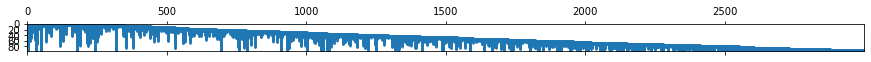

In [720]:
plt.figure(figsize=(15, 10))
plt.spy(PVM, precision=1e-4, markersize = 1);

Briefly, we find a dense block for each patch—that is, for each column in the patch-view matrix—by searching for all other patches that are visible in at least the same views. In practice, this strategy provides both a good coverage of the data by dense blocks, and an adequate overlap between blocks. Typically, patches appear in at least three or four views, depending on the separation between successive views in the sequence, and there are in general two orders of magnitude more patches than views.

In [721]:
def find_nonzero_runs(a):
    # Create an array that is 1 where a is nonzero, and pad each end with an extra 0.
    isnonzero = np.concatenate(([0], (np.asarray(a) != sparse_fill_value).view(np.int8), [0]))
    absdiff = np.abs(np.diff(isnonzero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges

In [722]:
patches_num = PVM.shape[1]
min_number_of_patches = 3
min_number_of_images = 3

dense_blocks_list = []

for i in range(patches_num-1):  # the last column may not start a block
    sequences = find_nonzero_runs(PVM[:, i])
    longest_seq = max(sequences, key=lambda x: x[1] - x[0])
    print(f'in column {i} the longest sequence indices: {longest_seq}')

    seq_len = longest_seq[1] - longest_seq[0]
    if seq_len < min_number_of_images*2:
        print(f'less than {min_number_of_images} images')
        continue
    else:
        for j in range(i+1, patches_num):
            # by searching for all other patches that are visible in at least the same views
            if any(PVM[longest_seq[0]: longest_seq[1], j] == sparse_fill_value):  # seq end condition
                if j - i > min_number_of_patches - 1:  # at least 2 points matched
                    dense_blocks_list.append((longest_seq[0], longest_seq[1], i, j))
                else:
                    print('do not make a dense matrix from one patch')
                break
            else:
                print('dense block is rising')

in column 0 the longest sequence indices: [0 4]
less than 3 images
in column 1 the longest sequence indices: [ 0 84]
dense block is rising
do not make a dense matrix from one patch
in column 2 the longest sequence indices: [ 0 98]
do not make a dense matrix from one patch
in column 3 the longest sequence indices: [ 0 44]
dense block is rising
dense block is rising
in column 4 the longest sequence indices: [ 0 98]
do not make a dense matrix from one patch
in column 5 the longest sequence indices: [ 0 66]
do not make a dense matrix from one patch
in column 6 the longest sequence indices: [ 0 10]
dense block is rising
do not make a dense matrix from one patch
in column 7 the longest sequence indices: [ 0 62]
do not make a dense matrix from one patch
in column 8 the longest sequence indices: [0 4]
less than 3 images
in column 9 the longest sequence indices: [0 4]
less than 3 images
in column 10 the longest sequence indices: [ 0 62]
do not make a dense matrix from one patch
in column 11 the

less than 3 images
in column 672 the longest sequence indices: [18 28]
dense block is rising
dense block is rising
in column 673 the longest sequence indices: [18 40]
dense block is rising
do not make a dense matrix from one patch
in column 674 the longest sequence indices: [18 40]
do not make a dense matrix from one patch
in column 675 the longest sequence indices: [18 22]
less than 3 images
in column 676 the longest sequence indices: [18 22]
less than 3 images
in column 677 the longest sequence indices: [20 30]
dense block is rising
do not make a dense matrix from one patch
in column 678 the longest sequence indices: [20 44]
do not make a dense matrix from one patch
in column 679 the longest sequence indices: [20 24]
less than 3 images
in column 680 the longest sequence indices: [20 30]
dense block is rising
do not make a dense matrix from one patch
in column 681 the longest sequence indices: [20 54]
do not make a dense matrix from one patch
in column 682 the longest sequence indices

less than 3 images
in column 1123 the longest sequence indices: [34 38]
less than 3 images
in column 1124 the longest sequence indices: [34 38]
less than 3 images
in column 1125 the longest sequence indices: [34 40]
dense block is rising
dense block is rising
dense block is rising
in column 1126 the longest sequence indices: [34 44]
do not make a dense matrix from one patch
in column 1127 the longest sequence indices: [34 42]
dense block is rising
do not make a dense matrix from one patch
in column 1128 the longest sequence indices: [34 48]
do not make a dense matrix from one patch
in column 1129 the longest sequence indices: [36 42]
do not make a dense matrix from one patch
in column 1130 the longest sequence indices: [36 40]
less than 3 images
in column 1131 the longest sequence indices: [36 42]
dense block is rising
dense block is rising
dense block is rising
dense block is rising
dense block is rising
dense block is rising
dense block is rising
dense block is rising
in column 1132 

less than 3 images
in column 1555 the longest sequence indices: [50 62]
do not make a dense matrix from one patch
in column 1556 the longest sequence indices: [50 56]
dense block is rising
do not make a dense matrix from one patch
in column 1557 the longest sequence indices: [50 56]
do not make a dense matrix from one patch
in column 1558 the longest sequence indices: [50 54]
less than 3 images
in column 1559 the longest sequence indices: [50 54]
less than 3 images
in column 1560 the longest sequence indices: [50 56]
dense block is rising
dense block is rising
in column 1561 the longest sequence indices: [50 58]
do not make a dense matrix from one patch
in column 1562 the longest sequence indices: [50 56]
do not make a dense matrix from one patch
in column 1563 the longest sequence indices: [50 54]
less than 3 images
in column 1564 the longest sequence indices: [50 54]
less than 3 images
in column 1565 the longest sequence indices: [50 54]
less than 3 images
in column 1566 the longest 

do not make a dense matrix from one patch
in column 2005 the longest sequence indices: [64 94]
do not make a dense matrix from one patch
in column 2006 the longest sequence indices: [64 68]
less than 3 images
in column 2007 the longest sequence indices: [64 74]
do not make a dense matrix from one patch
in column 2008 the longest sequence indices: [64 68]
less than 3 images
in column 2009 the longest sequence indices: [64 70]
dense block is rising
do not make a dense matrix from one patch
in column 2010 the longest sequence indices: [64 98]
do not make a dense matrix from one patch
in column 2011 the longest sequence indices: [64 68]
less than 3 images
in column 2012 the longest sequence indices: [64 68]
less than 3 images
in column 2013 the longest sequence indices: [64 68]
less than 3 images
in column 2014 the longest sequence indices: [64 68]
less than 3 images
in column 2015 the longest sequence indices: [64 68]
less than 3 images
in column 2016 the longest sequence indices: [64 70]

less than 3 images
in column 2400 the longest sequence indices: [76 98]
do not make a dense matrix from one patch
in column 2401 the longest sequence indices: [76 82]
do not make a dense matrix from one patch
in column 2402 the longest sequence indices: [76 80]
less than 3 images
in column 2403 the longest sequence indices: [76 98]
do not make a dense matrix from one patch
in column 2404 the longest sequence indices: [76 82]
dense block is rising
do not make a dense matrix from one patch
in column 2405 the longest sequence indices: [76 82]
do not make a dense matrix from one patch
in column 2406 the longest sequence indices: [76 80]
less than 3 images
in column 2407 the longest sequence indices: [76 80]
less than 3 images
in column 2408 the longest sequence indices: [76 80]
less than 3 images
in column 2409 the longest sequence indices: [76 90]
do not make a dense matrix from one patch
in column 2410 the longest sequence indices: [76 80]
less than 3 images
in column 2411 the longest se

in column 2861 the longest sequence indices: [90 96]
dense block is rising
dense block is rising
dense block is rising
dense block is rising
in column 2862 the longest sequence indices: [90 98]
dense block is rising
do not make a dense matrix from one patch
in column 2863 the longest sequence indices: [90 98]
do not make a dense matrix from one patch
in column 2864 the longest sequence indices: [90 96]
dense block is rising
do not make a dense matrix from one patch
in column 2865 the longest sequence indices: [90 98]
do not make a dense matrix from one patch
in column 2866 the longest sequence indices: [90 94]
less than 3 images
in column 2867 the longest sequence indices: [90 96]
do not make a dense matrix from one patch
in column 2868 the longest sequence indices: [90 94]
less than 3 images
in column 2869 the longest sequence indices: [90 94]
less than 3 images
in column 2870 the longest sequence indices: [90 96]
do not make a dense matrix from one patch
in column 2871 the longest se

In [723]:
dense_blocks_list

[(0, 44, 3, 6),
 (0, 6, 83, 88),
 (0, 6, 113, 116),
 (0, 6, 121, 124),
 (0, 6, 169, 172),
 (0, 8, 256, 259),
 (2, 8, 277, 282),
 (2, 8, 278, 282),
 (2, 10, 279, 282),
 (4, 10, 311, 316),
 (4, 12, 312, 316),
 (4, 12, 313, 316),
 (6, 12, 357, 360),
 (6, 12, 390, 393),
 (8, 18, 401, 404),
 (8, 14, 430, 433),
 (10, 16, 448, 451),
 (10, 16, 454, 459),
 (10, 16, 455, 459),
 (12, 18, 511, 514),
 (12, 18, 516, 519),
 (12, 18, 521, 524),
 (14, 24, 531, 534),
 (14, 20, 536, 543),
 (14, 20, 538, 543),
 (14, 22, 539, 542),
 (14, 22, 565, 568),
 (16, 22, 582, 587),
 (16, 22, 584, 587),
 (16, 22, 608, 612),
 (18, 24, 629, 632),
 (18, 24, 636, 639),
 (18, 24, 641, 645),
 (18, 24, 649, 652),
 (18, 24, 667, 670),
 (18, 28, 672, 675),
 (20, 26, 692, 696),
 (22, 28, 734, 737),
 (22, 28, 742, 746),
 (22, 28, 743, 746),
 (22, 28, 779, 783),
 (24, 32, 786, 793),
 (24, 32, 789, 793),
 (24, 30, 797, 800),
 (24, 30, 802, 809),
 (24, 32, 805, 809),
 (24, 30, 823, 828),
 (26, 32, 838, 841),
 (26, 32, 877, 884),


  0%|          | 0/223 [00:00<?, ?it/s]

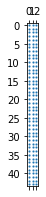

2m:  44
n:  3


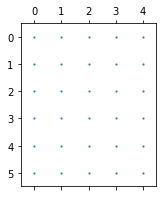

2m:  6
n:  5


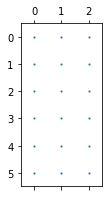

2m:  6
n:  3


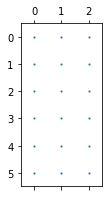

2m:  6
n:  3


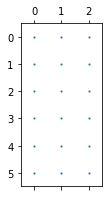

2m:  6
n:  3


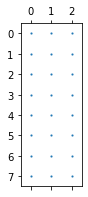

2m:  8
n:  3


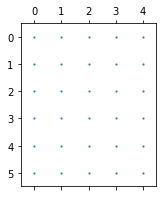

2m:  6
n:  5


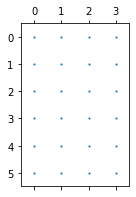

2m:  6
n:  4


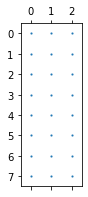

2m:  8
n:  3


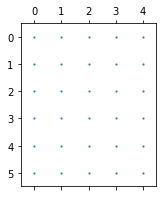

2m:  6
n:  5


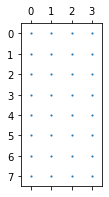

2m:  8
n:  4


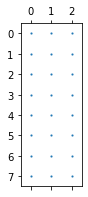

2m:  8
n:  3


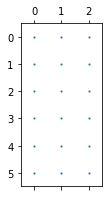

2m:  6
n:  3


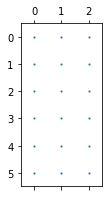

2m:  6
n:  3


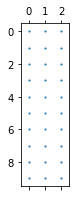

2m:  10
n:  3


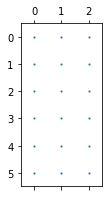

2m:  6
n:  3


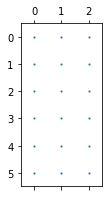

2m:  6
n:  3


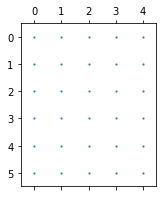

2m:  6
n:  5


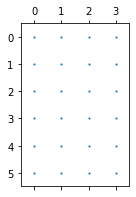

2m:  6
n:  4


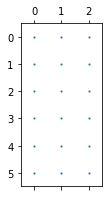

2m:  6
n:  3


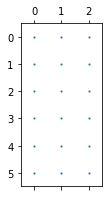

2m:  6
n:  3


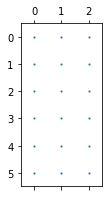

2m:  6
n:  3


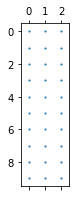

2m:  10
n:  3


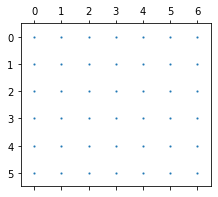

2m:  6
n:  7


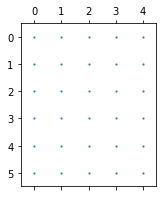

2m:  6
n:  5


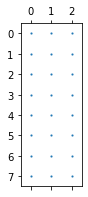

2m:  8
n:  3


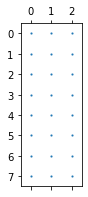

2m:  8
n:  3


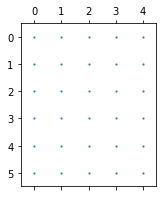

2m:  6
n:  5


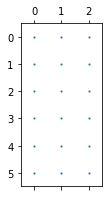

2m:  6
n:  3


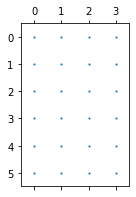

2m:  6
n:  4


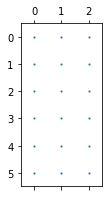

2m:  6
n:  3


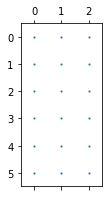

2m:  6
n:  3


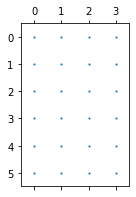

2m:  6
n:  4


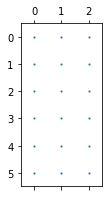

2m:  6
n:  3


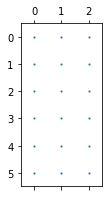

2m:  6
n:  3


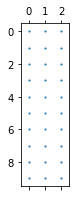

2m:  10
n:  3


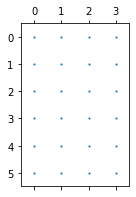

2m:  6
n:  4


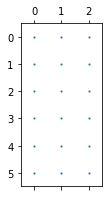

2m:  6
n:  3


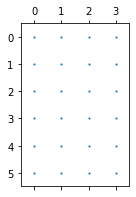

2m:  6
n:  4


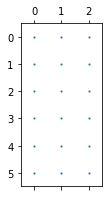

2m:  6
n:  3


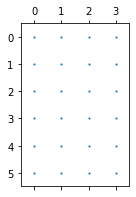

2m:  6
n:  4


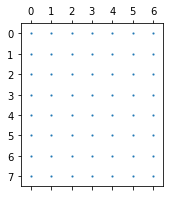

2m:  8
n:  7


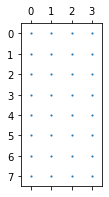

2m:  8
n:  4


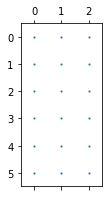

2m:  6
n:  3


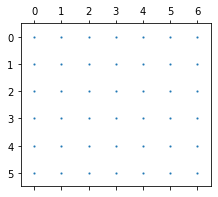

2m:  6
n:  7


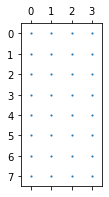

2m:  8
n:  4


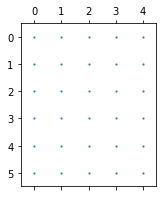

2m:  6
n:  5


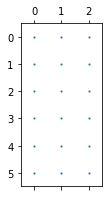

2m:  6
n:  3


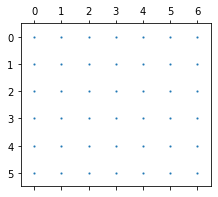

2m:  6
n:  7


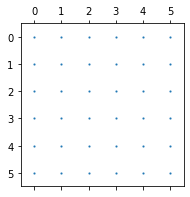

2m:  6
n:  6


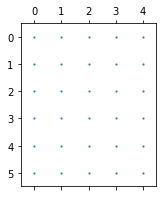

2m:  6
n:  5


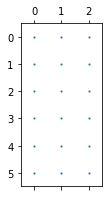

2m:  6
n:  3


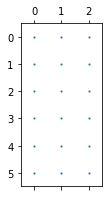

2m:  6
n:  3


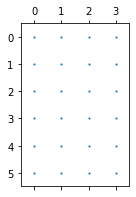

2m:  6
n:  4


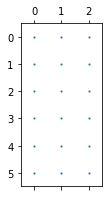

2m:  6
n:  3


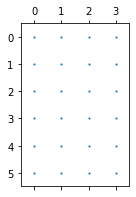

2m:  6
n:  4


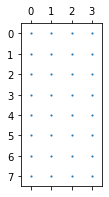

2m:  8
n:  4


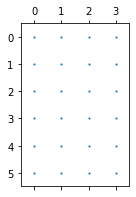

2m:  6
n:  4


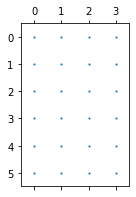

2m:  6
n:  4


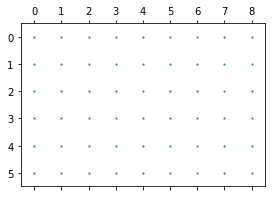

2m:  6
n:  9


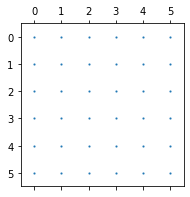

2m:  6
n:  6


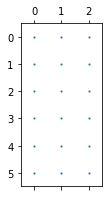

2m:  6
n:  3


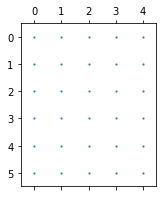

2m:  6
n:  5


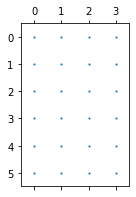

2m:  6
n:  4


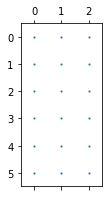

2m:  6
n:  3


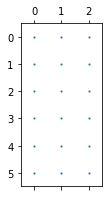

2m:  6
n:  3


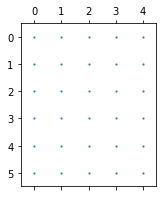

2m:  6
n:  5


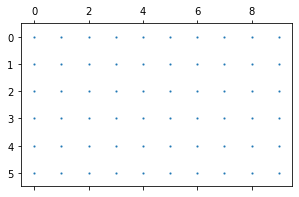

2m:  6
n:  10


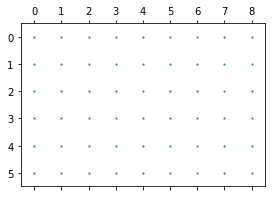

2m:  6
n:  9


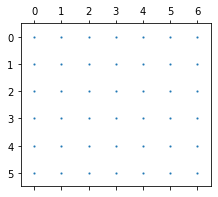

2m:  6
n:  7


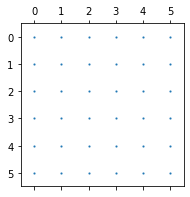

2m:  6
n:  6


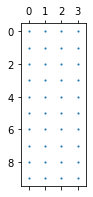

2m:  10
n:  4


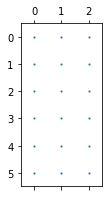

2m:  6
n:  3


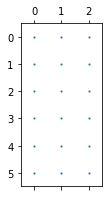

2m:  6
n:  3


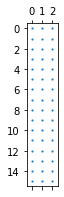

2m:  16
n:  3


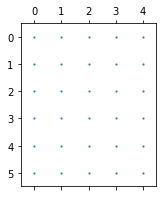

2m:  6
n:  5


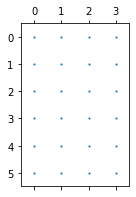

2m:  6
n:  4


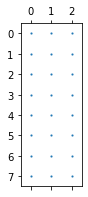

2m:  8
n:  3


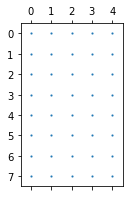

2m:  8
n:  5


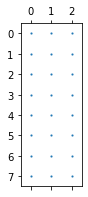

2m:  8
n:  3


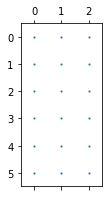

2m:  6
n:  3


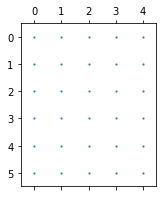

2m:  6
n:  5


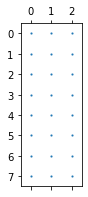

2m:  8
n:  3


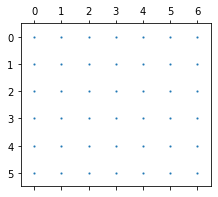

2m:  6
n:  7


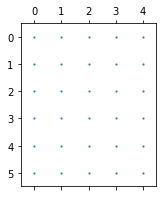

2m:  6
n:  5


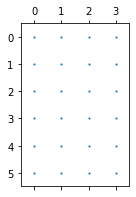

2m:  6
n:  4


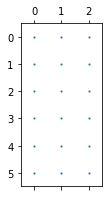

2m:  6
n:  3


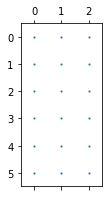

2m:  6
n:  3


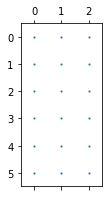

2m:  6
n:  3


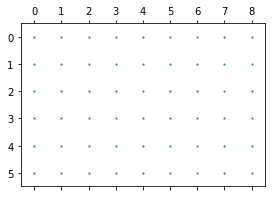

2m:  6
n:  9


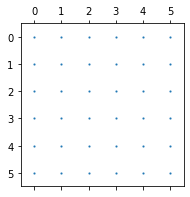

2m:  6
n:  6


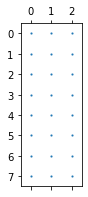

2m:  8
n:  3


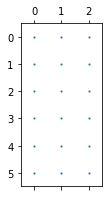

2m:  6
n:  3


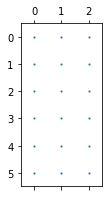

2m:  6
n:  3


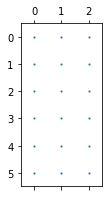

2m:  6
n:  3


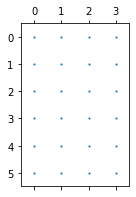

2m:  6
n:  4


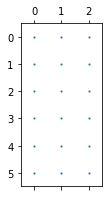

2m:  6
n:  3


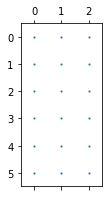

2m:  6
n:  3


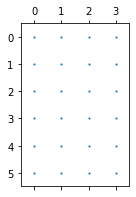

2m:  6
n:  4


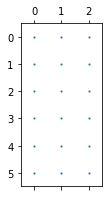

2m:  6
n:  3


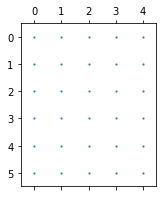

2m:  6
n:  5


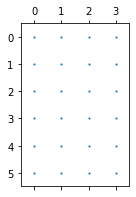

2m:  6
n:  4


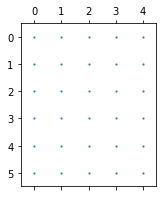

2m:  6
n:  5


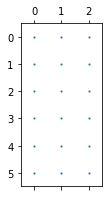

2m:  6
n:  3


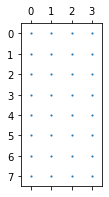

2m:  8
n:  4


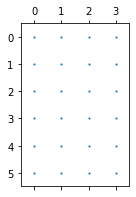

2m:  6
n:  4


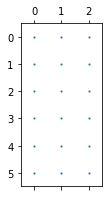

2m:  6
n:  3


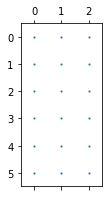

2m:  6
n:  3


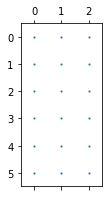

2m:  6
n:  3


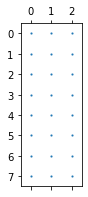

2m:  8
n:  3


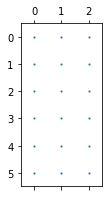

2m:  6
n:  3


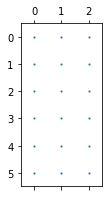

2m:  6
n:  3


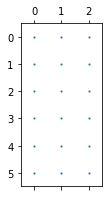

2m:  6
n:  3


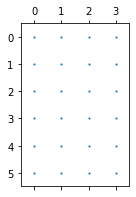

2m:  6
n:  4


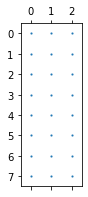

2m:  8
n:  3


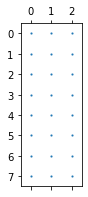

2m:  8
n:  3


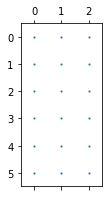

2m:  6
n:  3


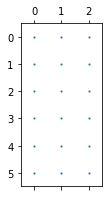

2m:  6
n:  3


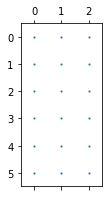

2m:  6
n:  3


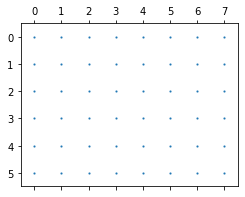

2m:  6
n:  8


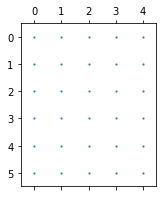

2m:  6
n:  5


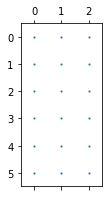

2m:  6
n:  3


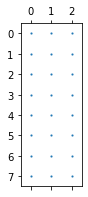

2m:  8
n:  3


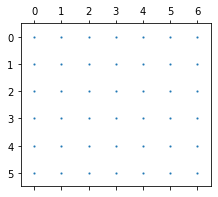

2m:  6
n:  7


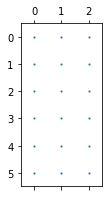

2m:  6
n:  3


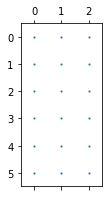

2m:  6
n:  3


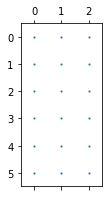

2m:  6
n:  3


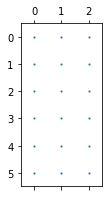

2m:  6
n:  3


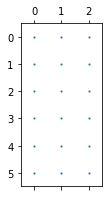

2m:  6
n:  3


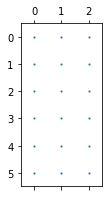

2m:  6
n:  3


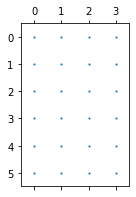

2m:  6
n:  4


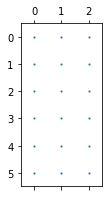

2m:  6
n:  3


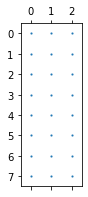

2m:  8
n:  3


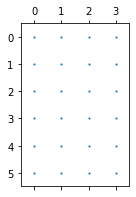

2m:  6
n:  4


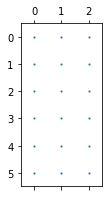

2m:  6
n:  3


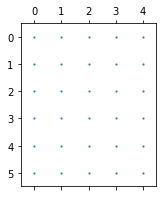

2m:  6
n:  5


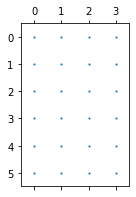

2m:  6
n:  4


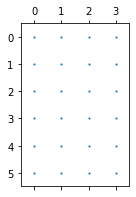

2m:  6
n:  4


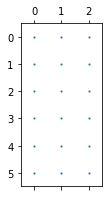

2m:  6
n:  3


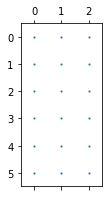

2m:  6
n:  3


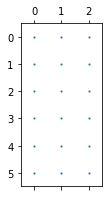

2m:  6
n:  3


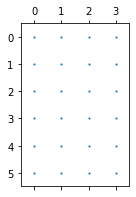

2m:  6
n:  4


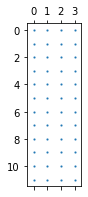

2m:  12
n:  4


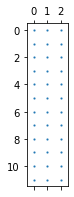

2m:  12
n:  3


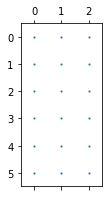

2m:  6
n:  3


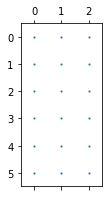

2m:  6
n:  3


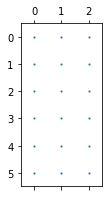

2m:  6
n:  3


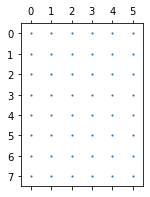

2m:  8
n:  6


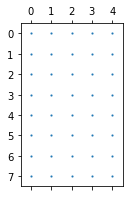

2m:  8
n:  5


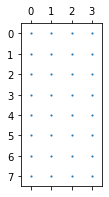

2m:  8
n:  4


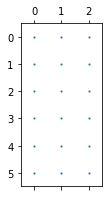

2m:  6
n:  3


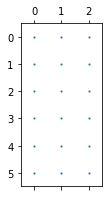

2m:  6
n:  3


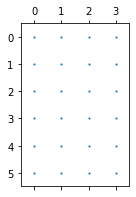

2m:  6
n:  4


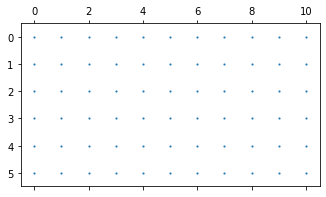

2m:  6
n:  11


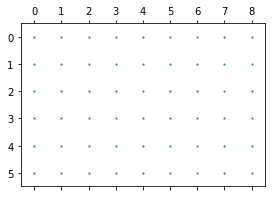

2m:  6
n:  9


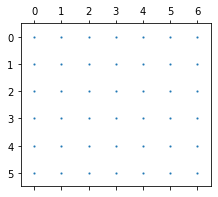

2m:  6
n:  7


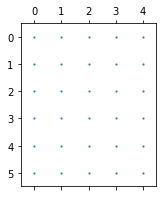

2m:  6
n:  5


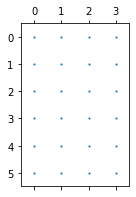

2m:  6
n:  4


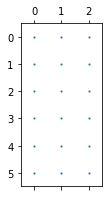

2m:  6
n:  3


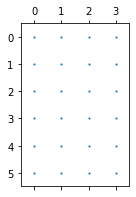

2m:  6
n:  4


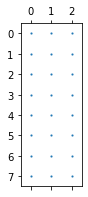

2m:  8
n:  3


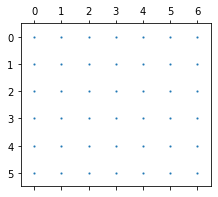

2m:  6
n:  7


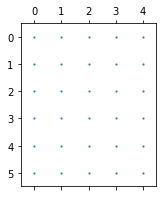

2m:  6
n:  5


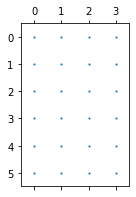

2m:  6
n:  4


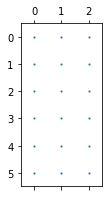

2m:  6
n:  3


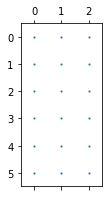

2m:  6
n:  3


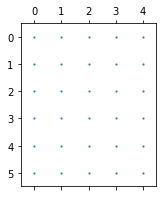

2m:  6
n:  5


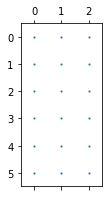

2m:  6
n:  3


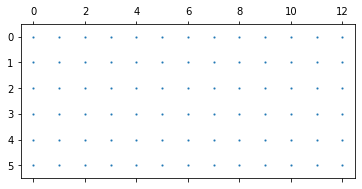

2m:  6
n:  13


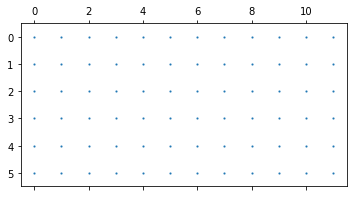

2m:  6
n:  12


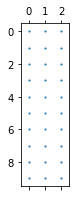

2m:  10
n:  3


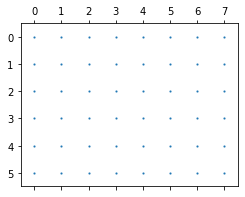

2m:  6
n:  8


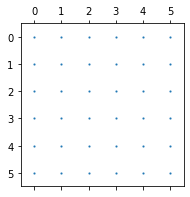

2m:  6
n:  6


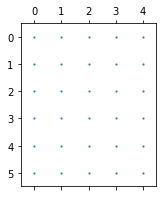

2m:  6
n:  5


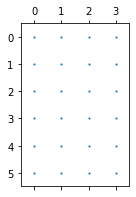

2m:  6
n:  4


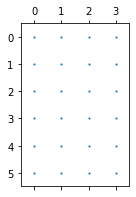

2m:  6
n:  4


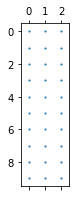

2m:  10
n:  3


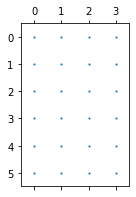

2m:  6
n:  4


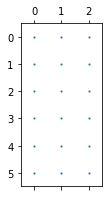

2m:  6
n:  3


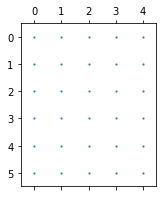

2m:  6
n:  5


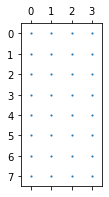

2m:  8
n:  4


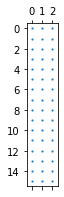

2m:  16
n:  3


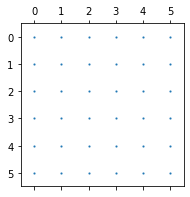

2m:  6
n:  6


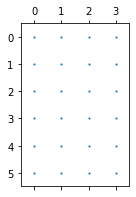

2m:  6
n:  4


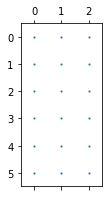

2m:  6
n:  3


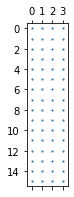

2m:  16
n:  4


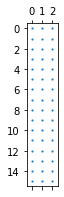

2m:  16
n:  3


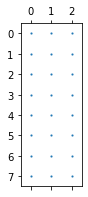

2m:  8
n:  3


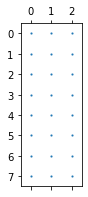

2m:  8
n:  3


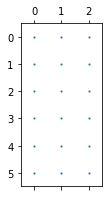

2m:  6
n:  3


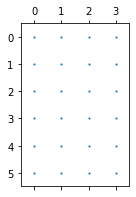

2m:  6
n:  4


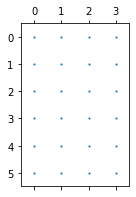

2m:  6
n:  4


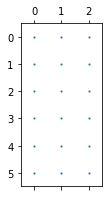

2m:  6
n:  3


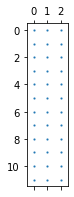

2m:  12
n:  3


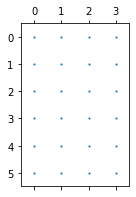

2m:  6
n:  4


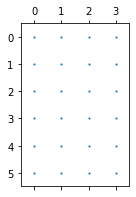

2m:  6
n:  4


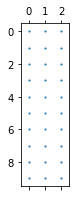

2m:  10
n:  3


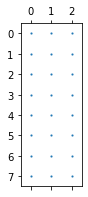

2m:  8
n:  3


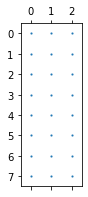

2m:  8
n:  3


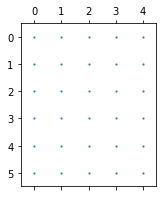

2m:  6
n:  5


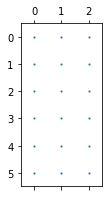

2m:  6
n:  3


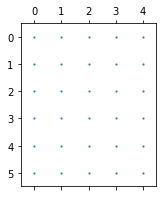

2m:  6
n:  5


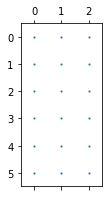

2m:  6
n:  3


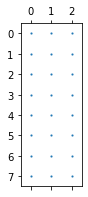

2m:  8
n:  3


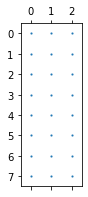

2m:  8
n:  3


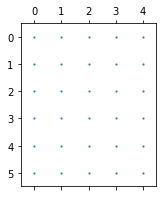

2m:  6
n:  5


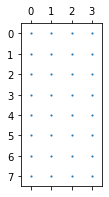

2m:  8
n:  4


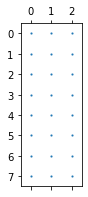

2m:  8
n:  3


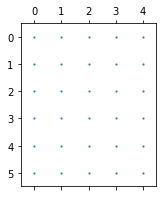

2m:  6
n:  5


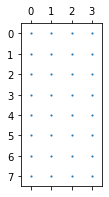

2m:  8
n:  4


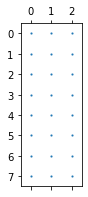

2m:  8
n:  3


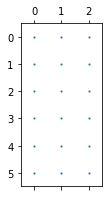

2m:  6
n:  3


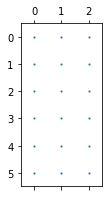

2m:  6
n:  3


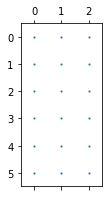

2m:  6
n:  3


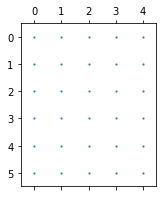

2m:  6
n:  5


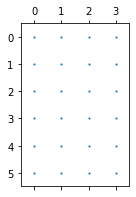

2m:  6
n:  4


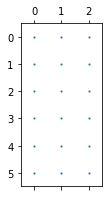

2m:  6
n:  3


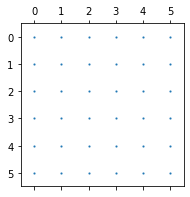

2m:  6
n:  6


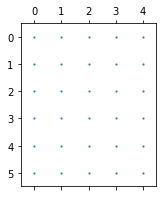

2m:  6
n:  5


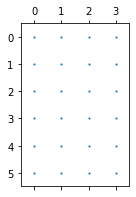

2m:  6
n:  4


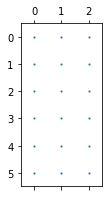

2m:  6
n:  3


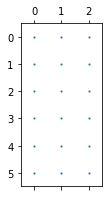

2m:  6
n:  3


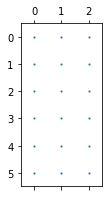

2m:  6
n:  3


In [724]:
from tqdm.notebook import tqdm

s_list = []
for dense_block in tqdm(dense_blocks_list, total=len(dense_blocks_list)):
    y1, y2, x1, x2 = dense_block

    plt.figure(figsize=(6, 3))
    plt.spy(PVM[y1: y2, x1: x2], precision=1e-4, markersize=1)
    plt.show()
    
    S = factorize_and_stitch(PVM[y1: y2, x1: x2])
    s_list.append(S)

procrustes receives two matrices. each matrix, n rows represent points in k (columns) space

In [725]:
from scipy.spatial import procrustes
from copy import deepcopy

Thus, in practice, we pick an arbitrary block as root, and iteratively register all others with this one using linear least squares, before using a non-linear method to refine the global registration parameters.  

We choose the largest block as root node and use its coordinate system as the global frame. We then find the best path from the root to every other node using a measure that maximizes the number of points shared by adjacent blocks, the rationale being that large overlaps will give reliable estimates of the corresponding (local) registration parameters. Specifically, we assign to each edge a capacity (number of points common to the blocks associated with the incident vertices), and use a form of Dijkstra’s algorithm to find for each vertex the path maximizing the capacity reaching the root.

In [726]:
def stardardize(mtx):
    trace_2 = (mtx @ mtx.T).trace()
    mtx_stand = mtx / np.sqrt(trace_2)
    return mtx_stand

In [727]:
mtx1_stand = stardardize(s_list[0])

already_alligned_standardized = [mtx1_stand]

for points_to_allign in s_list[1:]:
    
    root = np.vstack(already_alligned_standardized)
    points_to_allign = points_to_allign.T
    
    pad_num = root.shape[0] - points_to_allign.shape[0]
    print(f'accumulated shape: {root.shape[0]} procrusted with {points_to_allign.shape[0]}')

    if pad_num >= 0:
        shape_before = points_to_allign.shape
        print(f'Adding {pad_num} zero points to the new S')
        points_to_allign = np.pad(points_to_allign, [(0, abs(pad_num)), (0, 0)], constant_values=0)
    else:
        root = np.pad(root, [(0, abs(pad_num)), (0, 0)], constant_values=0)
        print(f'Adding {abs(pad_num)} zero points to the accumulated')
        
    print(f'Procrusting matrices of shapes {root.shape} and {points_to_allign.shape}')
    mtx1, mtx2, _ = procrustes(root, points_to_allign)
    
    # NOT SURE ABOUT THIS MOMENT
    if pad_num >= 0:  # returning to the original shape = dropping added zeros
        mtx2 = mtx2[: shape_before[0], :shape_before[1]]

    mtx2_stand = stardardize(mtx2)

    assert np.isclose((mtx2_stand @ mtx2_stand.T).trace(), 1.,
                      rtol=1e-05, atol=1e-08)
    assert np.isclose((mtx1 @ mtx1.T).trace(), 1.,
                      rtol=1e-05, atol=1e-08)

    already_alligned_standardized.append(mtx2_stand)
    print('\n')

accumulated shape: 3 procrusted with 5
Adding 2 zero points to the accumulated
Procrusting matrices of shapes (5, 3) and (5, 3)


accumulated shape: 8 procrusted with 3
Adding 5 zero points to the new S
Procrusting matrices of shapes (8, 3) and (8, 3)


accumulated shape: 11 procrusted with 3
Adding 8 zero points to the new S
Procrusting matrices of shapes (11, 3) and (11, 3)


accumulated shape: 14 procrusted with 3
Adding 11 zero points to the new S
Procrusting matrices of shapes (14, 3) and (14, 3)


accumulated shape: 17 procrusted with 3
Adding 14 zero points to the new S
Procrusting matrices of shapes (17, 3) and (17, 3)


accumulated shape: 20 procrusted with 5
Adding 15 zero points to the new S
Procrusting matrices of shapes (20, 3) and (20, 3)


accumulated shape: 25 procrusted with 4
Adding 21 zero points to the new S
Procrusting matrices of shapes (25, 3) and (25, 3)


accumulated shape: 29 procrusted with 3
Adding 26 zero points to the new S
Procrusting matrices of shapes (


accumulated shape: 419 procrusted with 5
Adding 414 zero points to the new S
Procrusting matrices of shapes (419, 3) and (419, 3)


accumulated shape: 424 procrusted with 3
Adding 421 zero points to the new S
Procrusting matrices of shapes (424, 3) and (424, 3)


accumulated shape: 427 procrusted with 4
Adding 423 zero points to the new S
Procrusting matrices of shapes (427, 3) and (427, 3)


accumulated shape: 431 procrusted with 4
Adding 427 zero points to the new S
Procrusting matrices of shapes (431, 3) and (431, 3)


accumulated shape: 435 procrusted with 3
Adding 432 zero points to the new S
Procrusting matrices of shapes (435, 3) and (435, 3)


accumulated shape: 438 procrusted with 3
Adding 435 zero points to the new S
Procrusting matrices of shapes (438, 3) and (438, 3)


accumulated shape: 441 procrusted with 3
Adding 438 zero points to the new S
Procrusting matrices of shapes (441, 3) and (441, 3)


accumulated shape: 444 procrusted with 3
Adding 441 zero points to the new 



accumulated shape: 821 procrusted with 3
Adding 818 zero points to the new S
Procrusting matrices of shapes (821, 3) and (821, 3)


accumulated shape: 824 procrusted with 5
Adding 819 zero points to the new S
Procrusting matrices of shapes (824, 3) and (824, 3)


accumulated shape: 829 procrusted with 3
Adding 826 zero points to the new S
Procrusting matrices of shapes (829, 3) and (829, 3)


accumulated shape: 832 procrusted with 3
Adding 829 zero points to the new S
Procrusting matrices of shapes (832, 3) and (832, 3)


accumulated shape: 835 procrusted with 3
Adding 832 zero points to the new S
Procrusting matrices of shapes (835, 3) and (835, 3)


accumulated shape: 838 procrusted with 5
Adding 833 zero points to the new S
Procrusting matrices of shapes (838, 3) and (838, 3)


accumulated shape: 843 procrusted with 4
Adding 839 zero points to the new S
Procrusting matrices of shapes (843, 3) and (843, 3)


accumulated shape: 847 procrusted with 3
Adding 844 zero points to the new

In [728]:
points = []

for mtx in already_alligned_standardized:
    p = o3d.geometry.PointCloud()
    p.points = o3d.utility.Vector3dVector(mtx)
    points.append(deepcopy(p))

In [729]:
o3d.visualization.draw_geometries(points) 

## 4 images